This cell mounts Google Drive in Colab and creates a structured project directory inside.This setup helps maintain a clean and organized project structure in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_PATH = "/content/drive/MyDrive/syNNapse_Inventory_ReID"
os.makedirs(BASE_PATH, exist_ok=True)

subdirs = [
    f"{BASE_PATH}/data",
    f"{BASE_PATH}/models",
    f"{BASE_PATH}/embeddings",
    f"{BASE_PATH}/results",
    f"{BASE_PATH}/src",
    f"{BASE_PATH}/notebooks"
]

for dir_path in subdirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"Created: {dir_path}")

print(f"\n Project setup complete at: {BASE_PATH}")

Mounted at /content/drive
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/data
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/models
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/embeddings
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/results
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/src
Created: /content/drive/MyDrive/syNNapse_Inventory_ReID/notebooks

 Project setup complete at: /content/drive/MyDrive/syNNapse_Inventory_ReID


This cell defines helper functions to save and load model checkpoints during training and ensures model weights and optimizer state are saved after each epoch and also the best-performing model is saved separately which is required for performing Module-B retrieval.

In [ ]:
import os, glob, shutil, gc, torch
BASE_PATH = "/content/drive/MyDrive/syNNapse_Inventory_ReID"
MODELS_DIR = os.path.join(BASE_PATH, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

def _atomic_torch_save(state, dest_path):
    tmp = os.path.join("/content", os.path.basename(dest_path))
    torch.save(state, tmp)
    try:
        shutil.move(tmp, dest_path)
    except Exception:
        torch.save(state, dest_path)
    return dest_path

def save_checkpoint_dict(state, filename="checkpoint_latest.pth"):
    path = os.path.join(MODELS_DIR, filename)
    _atomic_torch_save(state, path)
    print(f"[checkpoint] saved -> {path}")
    return path

def save_epoch_checkpoint(model, optimizer, epoch, loss=None, prefix="reid"):
    filename = f"{prefix}_epoch_{epoch:03d}.pth"
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }
    return save_checkpoint_dict(state, filename)

def save_best_checkpoint(model, optimizer, epoch, loss, prefix="reid"):
    filename = f"{prefix}_best.pth"
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }
    return save_checkpoint_dict(state, filename)

def latest_checkpoint(prefix="reid"):
    files = sorted(glob.glob(os.path.join(MODELS_DIR, f"{prefix}_epoch_*.pth")),
                   key=os.path.getmtime)
    return files[-1] if files else None

def load_checkpoint(filepath, model, optimizer=None, map_location="cpu"):
    print(f"[checkpoint] loading -> {filepath}")
    ckpt = torch.load(filepath, map_location=map_location)
    model.load_state_dict(ckpt["model_state_dict"])
    if optimizer is not None and "optimizer_state_dict" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt.get("epoch", 0) + 1
    return start_epoch, ckpt

def clear_cuda():
    gc.collect()
    try:
        torch.cuda.empty_cache()
    except Exception:
        pass

print("Checkpoint helpers ready. MODELS_DIR =", MODELS_DIR)


Checkpoint helpers ready. MODELS_DIR = /content/drive/MyDrive/syNNapse_Inventory_ReID/models


This ensures GPU utilisation if cuda is availaible.

In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

GPU: Tesla T4


This cells loads the dataset directly from kaggle

In [ ]:
import kagglehub
path = kagglehub.dataset_download("liucong12601/stanford-online-products-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'stanford-online-products-dataset' dataset.
Path to dataset files: /kaggle/input/stanford-online-products-dataset


This is just a sanity check to confirm the dataset is downloaded successfully and to see the folder structure.

In [ ]:
import os
print("Dataset path:", path)
print("\nTop-level files:")
print(os.listdir(path))

Dataset path: /kaggle/input/stanford-online-products-dataset

Top-level files:
['Stanford_Online_Products']


This cell verifies the structure of the downloaded Kaggle dataset. It defines `DATA_ROOT` by appending the main dataset folder (`Stanford_Online_Products`) to the raw path and lists the contents inside `DATA_ROOT` to confirm the dataset files are correctly located.
This step ensures the dataset directory is correctly structured before creating the Dataset or DataLoader.

In [ ]:
import os
print("Raw kagglehub path:", path)
DATA_ROOT = os.path.join(path, "Stanford_Online_Products")
print("DATA_ROOT:", DATA_ROOT)
print("Contents of DATA_ROOT:")
print(os.listdir(DATA_ROOT))


Raw kagglehub path: /kaggle/input/stanford-online-products-dataset
DATA_ROOT: /kaggle/input/stanford-online-products-dataset/Stanford_Online_Products
Contents of DATA_ROOT:
['table_final', 'Ebay_info.txt', 'cabinet_final.txt', 'LICENSE', 'bicycle_final', 'mug_final.txt', 'Ebay_test.txt', 'README', 'lamp_final', 'stapler_final', 'toaster_final', 'coffee_maker_final', 'Ebay_final.txt', 'mug_final', 'toaster_final.txt', 'chair_final.txt', 'sofa_final.txt', 'Ebay_train.txt', 'fan_final.txt', 'lamp_final.txt', 'coffee_maker_final.txt', 'fan_final', 'kettle_final', 'bicycle_final.txt', 'sofa_final', 'kettle_final.txt', 'cabinet_final', 'stapler_final.txt', 'table_final.txt', 'chair_final']


This cell lists all files and folders inside `DATA_ROOT`.It ensures the expected dataset files are present and correctly organized.

In [ ]:
import os
print("DATA_ROOT contents:")
for item in os.listdir(DATA_ROOT):
    print(item)


DATA_ROOT contents:
table_final
Ebay_info.txt
cabinet_final.txt
LICENSE
bicycle_final
mug_final.txt
Ebay_test.txt
README
lamp_final
stapler_final
toaster_final
coffee_maker_final
Ebay_final.txt
mug_final
toaster_final.txt
chair_final.txt
sofa_final.txt
Ebay_train.txt
fan_final.txt
lamp_final.txt
coffee_maker_final.txt
fan_final
kettle_final
bicycle_final.txt
sofa_final
kettle_final.txt
cabinet_final
stapler_final.txt
table_final.txt
chair_final


This cell checks whether image paths in the dataset annotations are correctly formatted and accessible.This step ensures that dataset annotations correctly map to real image files before building the Dataset and DataLoader.

In [ ]:
line = open(os.path.join(DATA_ROOT, "Ebay_train.txt")).readlines()[1]
rel_path = line.strip().split()[-1]
full_path = os.path.join(DATA_ROOT, rel_path)
print("Sample image path:", full_path)
print("Exists:", os.path.exists(full_path))


Sample image path: /kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/111085122871_0.JPG
Exists: True


This cell defines a helper function `parse_sop()` to read the SOP dataset annotation files and convert them into structured DataFrames.It reads `Ebay_train.txt` and `Ebay_test.txt`(skipping the header) and extracts the image file path and the corresponding item_id and creates a Pandas DataFrame with these 2 columns.
After parsing it prints the number of training and testing images, the number of unique item_ids in them and also verifies that all the image paths exists on disk.

This step prepares clean metadata tables required for building PyTorch Dataset and DataLoader objects.

In [ ]:
import pandas as pd
def parse_sop(txt_file, images_root):
    rows = []
    with open(txt_file, "r") as f:
        lines = f.readlines()[1:]
        for line in lines:
            _, class_id, _, rel_path = line.strip().split()
            rows.append({
                "image": os.path.join(images_root, rel_path),
                "item_id": class_id
            })
    return pd.DataFrame(rows)
images_root = DATA_ROOT

train_df = parse_sop(
    os.path.join(DATA_ROOT, "Ebay_train.txt"),
    images_root
)

test_df = parse_sop(
    os.path.join(DATA_ROOT, "Ebay_test.txt"),
    images_root
)

print("Train images:", len(train_df))
print("Test images:", len(test_df))
print("Train items:", train_df["item_id"].nunique())
print("Test items:", test_df["item_id"].nunique())

print("Missing train images:", (~train_df["image"].apply(os.path.exists)).sum())
print("Missing test images:", (~test_df["image"].apply(os.path.exists)).sum())


Train images: 59551
Test images: 60502
Train items: 11318
Test items: 11316
Missing train images: 0
Missing test images: 0


This cell creates a working directory (`/content/reid_project`) and saves the processed dataset metadata as CSV files.These CSV files provide a clean and reusable representation of the dataset, making it easier to load data later without re-parsing the original annotation files.

In [ ]:
WORKDIR = "/content/reid_project"
os.makedirs(WORKDIR, exist_ok=True)

train_df.to_csv(os.path.join(WORKDIR, "train_manifest.csv"), index=False)
test_df.to_csv(os.path.join(WORKDIR, "test_manifest.csv"), index=False)


These 2 cells below simply verify whether the required csv files---train and test were created as planned or not.

In [ ]:
train_df

,image,item_id
0,/kaggle/input/stanford-online-products-dataset...,1
1,/kaggle/input/stanford-online-products-dataset...,1
2,/kaggle/input/stanford-online-products-dataset...,1
3,/kaggle/input/stanford-online-products-dataset...,1
4,/kaggle/input/stanford-online-products-dataset...,1
...,...,...
59546,/kaggle/input/stanford-online-products-dataset...,11318
59547,/kaggle/input/stanford-online-products-dataset...,11318
59548,/kaggle/input/stanford-online-products-dataset...,11318
59549,/kaggle/input/stanford-online-products-dataset...,11318


In [ ]:
test_df

,image,item_id
0,/kaggle/input/stanford-online-products-dataset...,11319
1,/kaggle/input/stanford-online-products-dataset...,11319
2,/kaggle/input/stanford-online-products-dataset...,11319
3,/kaggle/input/stanford-online-products-dataset...,11319
4,/kaggle/input/stanford-online-products-dataset...,11319
...,...,...
60497,/kaggle/input/stanford-online-products-dataset...,22633
60498,/kaggle/input/stanford-online-products-dataset...,22634
60499,/kaggle/input/stanford-online-products-dataset...,22634
60500,/kaggle/input/stanford-online-products-dataset...,22634


These 2 cells extract and display the the images corresponding the item_id 11337 present in the test_csv which will later be also used in producing the sample output.

In [ ]:
test_df["item_id"] = test_df["item_id"].astype(int)
subset = test_df[test_df["item_id"] == 11337]
print(len(subset))

4


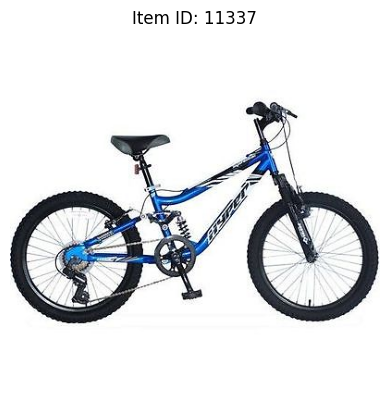

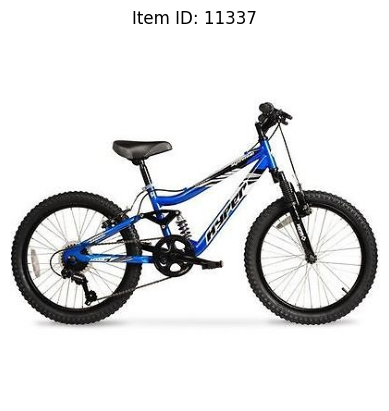

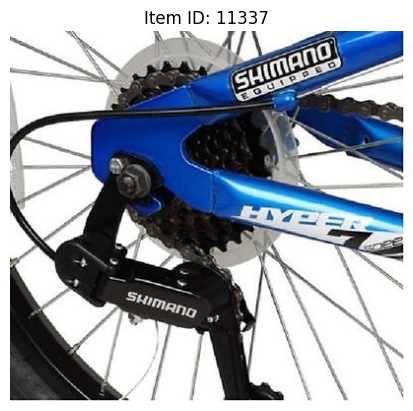

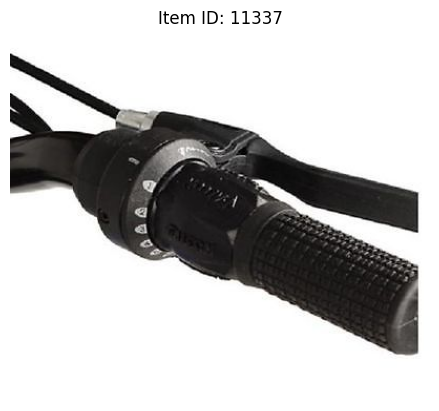

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for i, row in subset.iterrows():
    img = Image.open(row["image"]).convert("RGB")

    plt.figure()
    plt.imshow(img)
    plt.title(f"Item ID: {row['item_id']}")
    plt.axis("off")

This cell sets a fixed random seed (`SEED = 42`) to ensure reproducible results.
Additionally, it configures cuDNN to operate in deterministic mode to reduce non-deterministic behavior during GPU training.
This ensures that training runs produce consistent results across executions, which is important for debugging, comparison, and reproducibility.

In [ ]:
import os, random
import numpy as np
import torch

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"[seed] deterministic seed set -> {SEED}")

[seed] deterministic seed set -> 42


This cell creates a mapping between each unique `item_id` in the training dataset and a corresponding integer label with labels from 0 to the (number of unique ids-1).
Deep learning classification models (e.g., using `CrossEntropyLoss`) require class labels to be integer-encoded.  
This mapping ensures consistent and reproducible label indexing during training and evaluation.

In [ ]:
import json

train_item_ids = sorted(train_df["item_id"].unique())
item2label = {item_id: idx for idx, item_id in enumerate(train_item_ids)}

with open(os.path.join(WORKDIR, "item2label.json"), "w") as f:
    json.dump(item2label, f)

print("Total training classes:", len(item2label))


Total training classes: 11318


This cell randomly selects 5 images from the training dataset and displays them.
It helps verify dataset integrity before training the model.

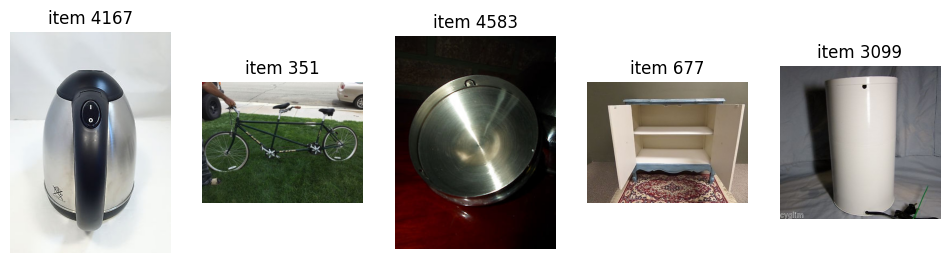

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

sample = train_df.sample(5)
plt.figure(figsize=(12,4))

for i, row in enumerate(sample.itertuples()):
    img = Image.open(row.image).convert("RGB")
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"item {row.item_id}")
    plt.axis("off")

plt.show()


This cell checks whether any `item_id`s appear in both the training and test sets which is an important check for the PS requirements.

In [ ]:
train_items = set(train_df["item_id"].unique())
test_items  = set(test_df["item_id"].unique())

overlap = train_items.intersection(test_items)

print("Number of overlapping item_ids:", len(overlap))


Number of overlapping item_ids: 0


This cells simply compares the number of unique item_ids in train and test dataset.

In [ ]:
num_train_items = len(train_items)
num_test_items  = len(test_items)
total_items = num_train_items + num_test_items

print("Train items:", num_train_items)
print("Test items:", num_test_items)
print("Train ratio:", num_train_items / total_items)
print("Test ratio:", num_test_items / total_items)


Train items: 11318
Test items: 11316
Train ratio: 0.5000441813201378
Test ratio: 0.49995581867986216


This cell checks whether the generated label indices are valid ,properly formatted and contiguous.
Classification models require labels to be consecutive integers starting from 0.  
This check ensures there are no missing or irregular label indices that could cause training errors.

In [ ]:
labels = sorted(item2label.values())

print("Min label:", labels[0])
print("Max label:", labels[-1])
print("Number of labels:", len(labels))
print("Is contiguous:", labels == list(range(len(labels))))


Min label: 0
Max label: 11317
Number of labels: 11318
Is contiguous: True


This cell creates two mappings between item IDs and integer labels.`id2label` maps each unique `item_id` to a corresponding integer index (0 to N−1).
and `label2id` creates the reverse mapping from integer label back to `item_id`.
eep learning models require integer-encoded labels for training.  
The reverse mapping (`label2id`) is useful for interpreting predictions and converting model outputs back to original item IDs.

In [ ]:
unique_ids = sorted(train_df['item_id'].unique())
id2label = {id_: i for i, id_ in enumerate(unique_ids)}
label2id = {i: id_ for id_, i in id2label.items()}

This cell creates a new column `label` in `train_df` by mapping each `item_id` to its corresponding integer index using `id2label`.
This step converts string-based `item_id`s into numeric labels that can be directly used during model training.

In [ ]:
train_df['label'] = train_df['item_id'].map(id2label)


The below 2 cells again just verify the changes in train and test csv files.

In [ ]:
train_df


,image,item_id,label
0,/kaggle/input/stanford-online-products-dataset...,1,0
1,/kaggle/input/stanford-online-products-dataset...,1,0
2,/kaggle/input/stanford-online-products-dataset...,1,0
3,/kaggle/input/stanford-online-products-dataset...,1,0
4,/kaggle/input/stanford-online-products-dataset...,1,0
...,...,...,...
59546,/kaggle/input/stanford-online-products-dataset...,11318,1467
59547,/kaggle/input/stanford-online-products-dataset...,11318,1467
59548,/kaggle/input/stanford-online-products-dataset...,11318,1467
59549,/kaggle/input/stanford-online-products-dataset...,11318,1467


The three cells below examine how many images belong to each training class.
Metric learning methods require multiple images per class to form positive pairs.  
This analysis ensures that the dataset has enough samples per class for effective training.

In [ ]:
class_counts = train_df["label"].value_counts()
print(class_counts.head(10))


label
7028    12
7985    12
358     12
1381    12
7054    12
3791    12
5097    12
4541    12
3884    12
8430    12
Name: count, dtype: int64


In [ ]:
class_counts.describe()


,count
count,11318.000000
mean,5.261619
std,2.978530
min,2.000000
25%,3.000000
50%,4.000000
75%,7.000000
max,12.000000


In [ ]:
def classes_with_at_least_k(k):
    return (class_counts >= k).sum()

for k in [2, 3, 4, 5, 6]:
    print(f"Classes with ≥{k} images:", classes_with_at_least_k(k))


Classes with ≥2 images: 11318
Classes with ≥3 images: 9180
Classes with ≥4 images: 7299
Classes with ≥5 images: 5532
Classes with ≥6 images: 4233


This cell defines image transformation pipelines for training and testing datasets.
The training pipeline applies data augmentation to improve model generalization along with normalisation and conversion of images to tensors.Data augmentation helps prevent overfitting and improves the model's ability to generalize to unseen data and makes it more robust towards viewpoint changes(RandomHorizontalFlip, RandomResizedCrop),lighting variations(ColorJitter),Background Clutter(RandomResizedCrop) and minor occlusions(RandomErasing) as demanded by the problem statement.
The test pipeline applies deterministic preprocessing such as resizing, conversion to tensors and normalisation necessary for consistency and fair evaluation.

In [ ]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.RandomErasing(p=0.5)

])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

This cell defines a custom PyTorch `Dataset` class for the Stanford Online Products (SOP) dataset.
What this code basically does is it reads the `idx`-th row from `df`,loads the image from disk using PIL and converts it to RGB and then applies the given transform pipeline (train_transform for train and test_transform for test) and then finally returns `(image_tensor, label_int)`for training dataset(is_train=True) or else returns `(image_tensor, item_id, image_path)` for the test dataset. It also returns the number of rows in the DataFrame, which is the number of samples in the dataset.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class SOPDataset(Dataset):
    def __init__(self, df, transform=None, is_train=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.image).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.is_train:
            return img, int(row.label)
        else:
            return img, row.item_id, row.image
    def __len__(self):
        return len(self.df)



This cell initializes two dataset objects using the custom `SOPDataset` class.
train_dataset is returned in the form `(image_tensor, label)` for model training and test_dataset is returned in the form `(image_tensor, item_id, image_path)` for retrieval evaluation.
Finally, it prints the number of samples in the training and test datasets to confirm correct dataset loading.

In [ ]:
train_dataset = SOPDataset(
    df=train_df,
    transform=train_transform,
    is_train=True
)

test_dataset = SOPDataset(
    df=test_df,
    transform=test_transform,
    is_train=False
)
print(len(train_dataset))
print(len(test_dataset))


59551
60502


This cell retrieves the first sample from `train_dataset` and prints its shape and label.This serves as a quick validation step before creating the DataLoader and starting training.
The correct shape of the image should be [number of channels* height *width] which here is 3,224,224 respectively.
The output validates this.

In [ ]:
img, label = train_dataset[0]
print(img.shape, label)


torch.Size([3, 224, 224]) 0


This cell simply prints the number of total samples or the size of train_dataset and also the number of unique samples(item ids) in the train_dataset.

In [ ]:
train_labels = [
    item2label[item_id]
    for item_id in train_dataset.df["item_id"]
]

print("Total labels:", len(train_labels))
print("Unique labels:", len(set(train_labels)))

Total labels: 59551
Unique labels: 11318


In this project, we train an embedding model for **Inventory Item Re-Identification**: given an image, the model outputs a fixed-length **embedding** such that images of the **same item ID** are close in feature space and **different item IDs** are far.For this we need P*K batches because Metric-learning losses (Triplet Loss used here) require **positives and negatives inside the same batch**:
- **Positives:** different images of the *same* item ID.
- **Negatives:** images from *different* item IDs.
A standard random DataLoader batch may contain many singletons (only 1 image per ID), which makes it hard to form useful positive pairs/triplets.PKBatchSampler guarantees that each training batch contains
- **P unique labels (item IDs)** per batch
- **K images per label**
So the batch size is **P × K**.
This creates a batch with rich positives/negatives, improving embedding learning and robustness.

What our code does is it builds a mapping: `label -> list of dataset indices`,
and keeps only labels that have at least `K` images and then shuffles labels in each epoch and then for each label, it randomly samples `K` indices
and after collecting `P` labels, it yields the combined index list as one batch.
After this the training and testing dataloaders are defined as follows:

- **Training:** `DataLoader(..., batch_sampler=PKBatchSampler(...))` so batching is controlled by the sampler (not by `batch_size`).
- **Testing:** a normal sequential DataLoader (`batch_size=128, shuffle=False`) is used to compute embeddings and perform retrieval for Top-K evaluation.

In [ ]:
import random
from collections import defaultdict
from torch.utils.data import Sampler, DataLoader

class PKBatchSampler(Sampler):
    def __init__(self, labels, P=16, K=4, drop_last=True):
        self.P = P
        self.K = K
        self.drop_last = drop_last

        self.label_to_indices = defaultdict(list)
        for idx, lab in enumerate(labels):
            self.label_to_indices[int(lab)].append(idx)

        self.valid_labels = [lab for lab, inds in self.label_to_indices.items() if len(inds) >= K]

        if len(self.valid_labels) < P:
            raise ValueError(f"Not enough classes with >=K samples. "
                             f"Have {len(self.valid_labels)}, need P={P}.")

    def __iter__(self):
        labels = self.valid_labels.copy()
        random.shuffle(labels)
        batch = []
        classes_in_batch = 0
        for lab in labels:
            inds = self.label_to_indices[lab]
            chosen = random.sample(inds, self.K)
            batch.extend(chosen)
            classes_in_batch += 1
            if classes_in_batch == self.P:
                yield batch
                batch = []
                classes_in_batch = 0
        if (not self.drop_last) and len(batch) > 0:
            yield batch
    def __len__(self):
        return len(self.valid_labels) // self.P

P = 16
K = 4
train_labels = train_df["label"].values

train_batch_sampler = PKBatchSampler(train_labels, P=P, K=K, drop_last=True)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_batch_sampler,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


In this step, we assign the `test_loader` to a new variable called `inventory_loader`.  
This is done to clearly represent its role in the retrieval pipeline.

In [ ]:
inventory_loader = test_loader
if 'test_dataset' in globals():
    inventory_dataset = test_dataset
else:
    inventory_dataset = None

print("inventory_loader set from test_loader")
print("inventory_dataset:", type(inventory_dataset))


inventory_loader set from test_loader
inventory_dataset: <class '__main__.SOPDataset'>


This cell is just a sanity check to verify the P×K Batch structure.
The batch size is P×K  which is 64 in our case which the output of this cell validates.

In [ ]:
import torch
imgs, labels = next(iter(train_loader))
print(imgs.shape)
print(torch.unique(labels).numel())
u, c = torch.unique(labels, return_counts=True)
print(c[:10])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


torch.Size([64, 3, 224, 224])
16
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])


Importing PyTorch and TorchVision Modules which is important for building and training a deep learning model for image embedding and retrieval.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


## 1. ResNet50 Architecture (CNN Baseline)

This section defines the baseline Convolutional Neural Network (CNN) approach. We utilize a pretrained ResNet50 backbone, stripping the final classification layer and replacing it with a custom 512-dimensional projection head to adapt the architecture for deep metric learning and open-set retrieval.

**ResNet50 Embedder and Direct Fine-Tuning Strategy**

This cell builds the custom visual encoder model and handles the hardware and training setup. It uses a ResNet50 backbone but replaces the standard classification head with a custom 512-dimensional embedding layer. L2 normalization is applied to these embeddings, which is a crucial step for getting accurate distance metrics during the Module B retrieval phase.
For the training strategy, `setup_direct_finetune` selectively freezes the early layers of the model and only unfreezes the top blocks and the new custom heads. This keeps the valuable pre-trained ImageNet weights intact while fine-tuning the model for the inventory dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class ResNet50Embedder(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()

        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.backbone = models.resnet50(weights=weights)

        self.backbone.fc = nn.Identity()

        self.embedding = nn.Linear(2048, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        emb = F.normalize(emb, p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_model(num_classes: int, ckpt_path: str = None, emb_dim: int = 512, pretrained: bool = True):
    device = get_device()
    model = ResNet50Embedder(num_classes=num_classes, emb_dim=emb_dim, pretrained=pretrained).to(device)

    if ckpt_path is not None:
        ckpt = torch.load(ckpt_path, map_location=device)
        state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt
        model.load_state_dict(state, strict=True)

    return model, device

def setup_direct_finetune(model, lr_head, lr_backbone, weight_decay=1e-4, freeze_bn_running_stats=True):

    for p in model.backbone.parameters():
        p.requires_grad = False

    for p in model.backbone.layer3.parameters():
        p.requires_grad = True
    for p in model.backbone.layer4.parameters():
        p.requires_grad = True
    for p in model.embedding.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True
    if freeze_bn_running_stats:
        def freeze_bn(m):
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        model.apply(freeze_bn)
    optimizer = torch.optim.AdamW([
        {"params": model.embedding.parameters(), "lr": lr_head},
        {"params": model.classifier.parameters(), "lr": lr_head},
        {"params": model.backbone.layer3.parameters(), "lr": lr_backbone},
        {"params": model.backbone.layer4.parameters(), "lr": lr_backbone},
    ], weight_decay=weight_decay)

    return optimizer

**Model Loading Utility**

This helper function initializes the ResNet50 embedding model and moves it to the appropriate device (CPU/GPU). It also optionally loads pretrained checkpoints if provided, ensuring easy resumption of training or inference. This keeps model initialization consistent and simplifies experimentation with saved weights.

In [ ]:
def load_model(num_classes, ckpt_path=None, emb_dim=512, pretrained=True):
    device = get_device()

    model = ResNet50Embedder(
        num_classes=num_classes,
        emb_dim=emb_dim,
        pretrained=pretrained
    ).to(device)

    if ckpt_path is not None:
        ckpt = torch.load(ckpt_path, map_location=device)
        state = ckpt.get("model_state_dict", ckpt)
        model.load_state_dict(state, strict=True)

    return model, device

These 2 cells install `pytorch-metric-learning` in the Correct Environment which is important for providing Metric learning losses which are to be used here.

In [ ]:
import sys
print(sys.executable)

/usr/bin/python3


In [ ]:
!{sys.executable} -m pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.3 MB/s eta 0:00:00


This code shows our metric learning setup which is Batch-Hard Triplet Loss + Cross-Entropy.

BatchHardMiner()` selects the hardest samples within each batch:

For every anchor:
- **Hardest positive** → same label, farthest embedding  
- **Hardest negative** → different label, closest embedding  

With **P×K batches**, this works well because:
- Each class has K positives
- There are many negatives from other classes  
- It forms difficult triplets:
\[
(anchor, hardest positive, hardest negative)
\] which leads to better and stronger embedding training.

Triplet loss directly shapes the embedding space, it brings the embeddings of the same class closer and pushes embeddings of different classes apart.
Mathematically:
\[
d(a,p) + margin < d(a,n)
\]
It forces a clear distance gap between same-class and different-class embeddings, which improves retrieval performance.

Cross-Entropy treats the task as standard classification. However the weightage of cross entropy loss is less compared to the weigtage of the triplet loss. It is used just to stabilize training,encourages discriminative feature learning
and prevents embedding collapse.

In [ ]:
from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss
miner = BatchHardMiner()
triplet_loss_fn = TripletMarginLoss(margin=0.3)
ce_loss_fn = nn.CrossEntropyLoss()
lambda_ce = 0.02

**Test Embedding Extraction**

This function extracts feature embeddings from the trained model for all test images. The model runs in evaluation mode without gradients to ensure stable inference. These embeddings are later used for similarity-based retrieval evaluation, while item IDs and image paths are stored alongside for analysis and visualization.

In [ ]:
import numpy as np
@torch.no_grad()
def extract_test_embeddings(model, test_loader, device):
    model.eval()

    all_emb = []
    all_item_ids = []
    all_paths = []

    for imgs, item_ids, paths in tqdm(test_loader):
        imgs = imgs.to(device)
        emb, _ = model(imgs)
        all_emb.append(emb.cpu())

        all_item_ids.extend(item_ids)
        all_paths.extend(paths)

    all_emb = torch.cat(all_emb, dim=0)  # [N, D]
    return all_emb, np.array(all_item_ids), np.array(all_paths)


This installs FAISS (CPU Version) which is a library for efficient nearest neighbor search, large-scale similarity search,fast vector indexing and retrieval and is commonly used in:image retrieval ,re-identification systems and embedding-based search systems

In [ ]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 91.3 MB/s eta 0:00:00


This cell implements the specific evaluation metric required for the competition: Top-K Retrieval Accuracy.

* **Efficient Similarity Search:** It uses the `FAISS` library to handle the computation of nearest-neighbor retrieval. By applying `IndexFlatIP` on L2-normalized embeddings, it efficiently calculates the Cosine Similarity between the query image and the entire test gallery.
* **Strict Problem Statement Alignment:** The function logic perfectly mirrors the test-time retrieval setup defined in the PS. For every unique item ID, it randomly selects one image to act as the query and treats the rest as the database. It explicitly filters out the query image itself from the results to prevent data leakage.
* **Module B Evaluation:** It calculates whether the correct item ID successfully appears in the `Top-1`, `Top-5` (the primary metric), and `Top-10` retrieved results. This is the core function needed to validate how well the visual encoder is actually performing the open-set retrieval task on unseen data.

In [ ]:
import numpy as np
import faiss
import random
from collections import defaultdict
import torch

@torch.no_grad()
def topk_retrieval_accuracy_ps_style(
    emb,
    item_ids,
    ks=(1, 5, 10),
    seed=42,
    normalize=True,
    extra_neighbors=50
):
    if torch.is_tensor(emb):
        emb = emb.detach().cpu().numpy()
    emb = emb.astype("float32")

    if torch.is_tensor(item_ids):
        item_ids = item_ids.detach().cpu().tolist()
    item_ids = np.asarray(item_ids)

    N, D = emb.shape
    if N == 0:
        return {k: 0.0 for k in ks}, 0

    if normalize:
        faiss.normalize_L2(emb)

    index = faiss.IndexFlatIP(D)
    index.add(emb)

    groups = defaultdict(list)
    for i, iid in enumerate(item_ids):
        groups[iid].append(i)

    rng = random.Random(seed)
    max_k = max(ks)
    acc = {k: 0 for k in ks}
    n_queries = 0

    search_k = min(N, max_k + 1 + extra_neighbors)

    for iid, idxs in groups.items():
        if len(idxs) < 2:
            continue

        q_idx = rng.choice(idxs)
        q = emb[q_idx:q_idx + 1]

        sims, nbrs = index.search(q, search_k)
        nbrs = nbrs[0].tolist()

        filtered = [j for j in nbrs if j != -1 and j != q_idx]
        retrieved_ids = item_ids[filtered] if filtered else np.array([])

        for k in ks:
            kk = min(k, len(retrieved_ids))
            if kk > 0 and (iid in retrieved_ids[:kk]):
                acc[k] += 1

        n_queries += 1

    for k in ks:
        acc[k] /= max(1, n_queries)

    return acc, n_queries

***

This cell initializes the model architecture and configures the optimizer for the fine-tuning phase.

* **Dynamic Class Sizing:** It calculates the total number of unique labels directly from `train_df` to dynamically set `num_classes`. This ensures the classification head matches the exact number of inventory items in the training set.
* **Model Initialization:** It instantiates the pre-trained visual encoder using `load_model`, setting the embedding dimension to `512`, and automatically assigns the model to the detected hardware `device`.
* **Optimizer Configuration:** It sets up the optimization strategy using `setup_direct_finetune`. It applies a differential learning rate: a higher rate (`3e-4`) for the newly initialized custom heads and a lower, conservative rate (`3e-5`) for the unfreezed backbone layers. This, combined with freezing the batch normalization running statistics, ensures stable training without aggressively distorting the valuable pre-trained features.

***

In [ ]:
num_classes = train_df["label"].nunique()

model, device = load_model(
    num_classes=num_classes,
    ckpt_path=None,
    emb_dim=512,
    pretrained=True
)

optimizer = setup_direct_finetune(
    model,
    lr_head=3e-4,
    lr_backbone=3e-5,
    weight_decay=1e-4,
    freeze_bn_running_stats=True
)
print("device:", device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


device: cuda


***

This cell implements the full evaluation loop for testing the model's retrieval performance on the test set.

* **Efficient Inference:** It uses `@torch.no_grad()` and sets the `model` to evaluation mode (`model.eval()`). This disables gradient tracking, making the inference fast and memory-efficient.
* **Dynamic Batch Handling:** The loop through the `test_loader` features robust parsing logic. It dynamically handles various batch structures (dictionaries, lists, or tuples) and model output formats to extract the images and `item_id` without breaking.
* **Global Feature Aggregation:** Instead of evaluating performance batch-by-batch, it extracts embeddings for every image and aggregates them into global variables (`all_emb` and `all_ids`). This global aggregation is strictly necessary because the problem statement mandates an open-set retrieval setting, where every test image must be queried against the entire remaining test gallery.
* **Metric Calculation:** Finally, it feeds these aggregated features into the custom `topk_retrieval_accuracy_ps_style` function to compute the final `Top-1`, `Top-5`, and `Top-10` accuracies.

***

In [ ]:
@torch.no_grad()
def evaluate(model, test_loader, device, ks=(1, 5, 10)):
    model.eval()

    all_emb = []
    all_ids = []

    for batch in test_loader:

        if isinstance(batch, dict):
            if "image" in batch:
                imgs = batch["image"]
            elif "images" in batch:
                imgs = batch["images"]
            elif "pixel_values" in batch:
                imgs = batch["pixel_values"]
            else:
                raise KeyError(f"Unknown image key. Got keys: {list(batch.keys())}")

            if "item_id" in batch:
                item_id = batch["item_id"]
            elif "item_ids" in batch:
                item_id = batch["item_ids"]
            elif "label" in batch:
                item_id = batch["label"]
            else:
                raise KeyError(f"Unknown item_id key. Got keys: {list(batch.keys())}")

        elif isinstance(batch, list) and len(batch) > 0 and isinstance(batch[0], dict):
            imgs = torch.stack([b["image"] for b in batch], dim=0)
            item_id = [b["item_id"] for b in batch]
        elif isinstance(batch, (tuple, list)):
            imgs = batch[0]
            item_id = batch[1]
        else:
            raise TypeError(f"Unsupported batch type: {type(batch)}")

        imgs = imgs.to(device, non_blocking=True)

        out = model(imgs)

        if isinstance(out, (tuple, list)):
            emb = out[0]
        elif isinstance(out, dict):
            emb = out.get("emb", out.get("embedding", out.get("last_hidden_state")))
            if emb is None:
                raise KeyError(f"Model output dict keys not understood: {list(out.keys())}")
        else:
            emb = out
        if emb.ndim == 3:
            emb = emb[:, 0, :]
        elif emb.ndim > 3:
            emb = emb.flatten(1)

        all_emb.append(emb.detach().cpu())
        if torch.is_tensor(item_id):
            all_ids.extend(item_id.detach().cpu().tolist())
        elif isinstance(item_id, (list, tuple, np.ndarray)):
            all_ids.extend(list(item_id))
        else:
            all_ids.append(int(item_id))

    all_emb = torch.cat(all_emb, dim=0)

    acc_dict, n_queries = topk_retrieval_accuracy_ps_style(
        all_emb, all_ids, ks=ks, seed=42, normalize=True, extra_neighbors=50
    )
    return acc_dict, n_queries

***

This cell defines the core training loop for a single epoch using a joint optimization strategy.

* **Hard Triplet Mining:** During the forward pass, the loop uses an online `miner` to actively hunt for the hardest positive and negative examples within the current batch. This forces the model to learn the fine-grained visual differences between closely related inventory items, structuring the embedding space so that matching items cluster tightly together while different items are pushed apart.
* **Combined Loss Objective:** The total loss blends the triplet loss with the standard cross-entropy loss using a weighting factor (`lambda_ce`). The cross-entropy loss acts as a stabilizing regularizer for the classifier head, while the triplet loss directly optimizes the embeddings required for the Module B similarity search.
* **Optimization Efficiency:** It handles the standard PyTorch backward pass and weight updates, explicitly using `set_to_none=True` in `optimizer.zero_grad()` for a slight memory and performance boost, while tracking the average losses to monitor training stability.

***

In [ ]:
from tqdm import tqdm
import torch

def train_one_epoch(model, train_loader, optimizer, device, lambda_ce):
    model.train()

    total_loss = 0.0
    total_triplet = 0.0
    total_ce = 0.0
    n_batches = 0

    for imgs, labels in tqdm(train_loader, desc="train", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        emb, logits = model(imgs)

        hard_triplets = miner(emb, labels)
        loss_t = triplet_loss_fn(emb, labels, hard_triplets)

        loss_ce = ce_loss_fn(logits, labels)

        loss = loss_t + lambda_ce * loss_ce

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_triplet += loss_t.item()
        total_ce += loss_ce.item()
        n_batches += 1

    return {
        "loss": total_loss / n_batches,
        "triplet": total_triplet / n_batches,
        "ce": total_ce / n_batches,
    }


***

This cell acts as a quick sanity check to verify the model's forward pass before starting the actual training.

It moves a single batch of `imgs` to the active hardware `device` and feeds them through the network. The model returns two distinct outputs:
* **Embeddings:** The 512-dimensional L2-normalized vectors (`emb`) which are essential for the Module B similarity retrieval.
* **Logits:** The raw classification scores (`logits`) used for the Cross-Entropy loss.

Printing `emb.shape` and `logits.shape` confirms that the custom heads are correctly configured and returning the expected dimensions.

***

In [ ]:
imgs = imgs.to(device)
emb, logits = model(imgs)
print(emb.shape, logits.shape)


torch.Size([64, 512]) torch.Size([64, 11318])


***

This cell runs the main training loop, which we've set for 20 epochs, alternating between training the model and evaluating its performance on the test gallery. *(Note: We actually only ran it for 16 epochs here due to limited compute runtime!)*

* **Epoch Execution:** During each epoch, it calls `train_one_epoch` to update the model weights and then immediately runs the `evaluate` function to see how the model is performing on the retrieval task. It prints out the Triplet and Cross-Entropy losses along with the retrieval accuracies to monitor progress.
* **Metric-Driven Saving:** The crucial part of this loop is the automated checkpointing. Since the problem statement defines `Top-5` retrieval accuracy as the primary metric, the code actively tracks that specific score.
* **Model Preservation:** Whenever the model hits a new high `Top-5` accuracy, it saves those exact weights to `best_model.pt`. This ensures that the absolute best version of the model is preserved for the final similarity retrieval tasks, preventing us from losing progress if the model starts to overfit in the later stages.

***

In [ ]:
import torch

best_top5 = 0.0
epochs = 20

for epoch in range(1, epochs + 1):

    metrics = train_one_epoch(
        model,
        train_loader,
        optimizer,
        device,
        lambda_ce=lambda_ce
    )

    print(
        f"Epoch {epoch}/{epochs} | "
        f"loss={metrics['loss']:.4f} | "
        f"triplet={metrics['triplet']:.4f} | "
        f"ce={metrics['ce']:.4f}"
    )

    acc_dict, n_queries = evaluate(model, test_loader, device)

    print(
        f"Retrieval | "
        f"Top1={acc_dict.get(1,0):.4f} "
        f"Top5={acc_dict.get(5,0):.4f} "
        f"Top10={acc_dict.get(10,0):.4f}"
    )

    if acc_dict.get(5,0) > best_top5:
        best_top5 = acc_dict.get(5,0)

        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "epoch": epoch,
                "top5": best_top5
            },
            "best_model.pt"
        )

        print(f"Saved best_model.pt (Top5={best_top5:.4f})")

train:   0%|          | 0/456 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
                                                        

Epoch 1/20 | loss=3.1331 | triplet=0.3279 | ce=9.3506


Retrieval | Top1=0.6123 Top5=0.7279 Top10=0.7681
Saved best_model.pt (Top5=0.7279)


Epoch 2/20 | loss=3.0340 | triplet=0.2931 | ce=9.1364


Retrieval | Top1=0.6412 Top5=0.7557 Top10=0.7952
Saved best_model.pt (Top5=0.7557)


Epoch 3/20 | loss=2.9611 | triplet=0.2836 | ce=8.9248


Retrieval | Top1=0.6515 Top5=0.7652 Top10=0.8066
Saved best_model.pt (Top5=0.7652)


Epoch 4/20 | loss=2.9186 | triplet=0.2721 | ce=8.8216


Retrieval | Top1=0.6584 Top5=0.7726 Top10=0.8114
Saved best_model.pt (Top5=0.7726)


Epoch 5/20 | loss=2.8885 | triplet=0.2693 | ce=8.7305


Retrieval | Top1=0.6628 Top5=0.7738 Top10=0.8140
Saved best_model.pt (Top5=0.7738)


Epoch 6/20 | loss=2.8563 | triplet=0.2636 | ce=8.6422


Retrieval | Top1=0.6667 Top5=0.7777 Top10=0.8165
Saved best_model.pt (Top5=0.7777)


Epoch 7/20 | loss=2.8287 | triplet=0.2622 | ce=8.5551


Retrieval | Top1=0.6693 Top5=0.7774 Top10=0.8150


Epoch 8/20 | loss=2.8031 | triplet=0.2621 | ce=8.4702


Retrieval | Top1=0.6694 Top5=0.7827 Top10=0.8192
Saved best_model.pt (Top5=0.7827)


Epoch 9/20 | loss=2.7756 | triplet=0.2596 | ce=8.3866


Retrieval | Top1=0.6705 Top5=0.7813 Top10=0.8205


Epoch 10/20 | loss=2.7439 | triplet=0.2533 | ce=8.3017


Retrieval | Top1=0.6729 Top5=0.7856 Top10=0.8253
Saved best_model.pt (Top5=0.7856)


Epoch 11/20 | loss=2.7183 | triplet=0.2520 | ce=8.2212


Retrieval | Top1=0.6737 Top5=0.7871 Top10=0.8244
Saved best_model.pt (Top5=0.7871)


Epoch 12/20 | loss=2.6935 | triplet=0.2511 | ce=8.1415


Retrieval | Top1=0.6729 Top5=0.7874 Top10=0.8248
Saved best_model.pt (Top5=0.7874)


Epoch 13/20 | loss=2.6697 | triplet=0.2511 | ce=8.0622


Retrieval | Top1=0.6745 Top5=0.7884 Top10=0.8250
Saved best_model.pt (Top5=0.7884)


Epoch 14/20 | loss=2.6434 | triplet=0.2479 | ce=7.9851


Retrieval | Top1=0.6758 Top5=0.7862 Top10=0.8232


Epoch 15/20 | loss=2.6179 | triplet=0.2451 | ce=7.9094


Retrieval | Top1=0.6728 Top5=0.7903 Top10=0.8264
Saved best_model.pt (Top5=0.7903)


Epoch 16/20 | loss=2.5970 | triplet=0.2470 | ce=7.8333


Retrieval | Top1=0.6755 Top5=0.7874 Top10=0.8285


KeyboardInterrupt: 

This cell installs the timm (PyTorch Image Models) library.

## 2. Swin Transformer Architecture (Hierarchical ViT)

This section explores a hierarchical Vision Transformer approach using the Swin Transformer. By leveraging shifted window attention, this architecture aims to capture both local textures and global structural features, projecting the resulting high-dimensional features into a normalized 512-dimensional embedding space.

In [ ]:
pip install timm

***

This cell defines an upgraded visual encoder architecture leveraging the `timm` library, allowing for more advanced backbones beyond standard ResNet models.

* **Flexible Backbone Integration:** The `TransformerEmbedder` class is designed to dynamically load any pre-trained model from the `timm` library (like Vision Transformers or Swin Transformers). By setting `num_classes=0`, we remove the default ImageNet classifier and use the backbone strictly as a feature extractor.
* **Custom Embedding Head:** It takes the raw features from the backbone and passes them through a custom `nn.Linear` layer to project them into a `512`-dimensional embedding space.
* **Normalization for Retrieval:** Just like our previous model, it applies `F.normalize` to the embeddings. This ensures they sit on a unit hypersphere, which is vital for the cosine similarity calculations used in the Module B retrieval task.
* **Dual Output:** The `forward` pass returns both the normalized `emb` (for similarity searching) and the classification `logits` (for training with Cross-Entropy loss).

***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
class TransformerEmbedder(nn.Module):
    def __init__(self, backbone_name: str, num_classes: int, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
        )

        feat_dim = self.backbone.num_features

        self.embedding = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        emb = F.normalize(emb, p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

***

This cell implements a specialized fine-tuning strategy for Swin Transformer backbones, allowing for precise control over which parts of the network are updated.

* **Hierarchical Stage Management:** The `collect_swin_stages` helper identifies the major architectural blocks (stages) within the Swin backbone. This is important because hierarchical transformers process visual information at different scales across these stages.
* **Surgical Unfreezing:** The `setup_swin_dynamic_unfreeze` function starts by freezing the entire model to preserve pre-trained knowledge. It then selectively unfreezes the custom `embedding` and `classifier` heads, along with a user-defined number of the final backbone stages (`n_last_stages`). This allows the model to adapt its high-level feature extraction to our specific inventory items while keeping the base visual features intact.
* **Normalization Stability:** By forcing normalization layers into `eval()` mode via `freeze_norm_running_stats`, the model avoids updating running mean and variance statistics during fine-tuning.
* **Differential Learning Rates:** Finally, it constructs an `AdamW` optimizer with separate parameter groups. This allows us to use a higher learning rate for the new heads and a much lower, more conservative rate for the transformer backbone, preventing the optimizer from "washing away" the pre-trained weights.

***

In [ ]:
import torch
import torch.nn as nn

def collect_swin_stages(backbone):
    if hasattr(backbone, "layers"):
        return list(backbone.layers)

    stages = []
    for name, child in backbone.named_children():
        if name.startswith("layer") or name.startswith("stage") or "block" in name:
            stages.append(child)
    return stages

def setup_swin_dynamic_unfreeze(
    model,
    n_last_stages: int,
    lr_head: float,
    lr_backbone: float,
    weight_decay_head: float = 1e-4,
    weight_decay_backbone: float = 1e-5,
    freeze_norm_running_stats: bool = True
):

    for p in model.parameters():
        p.requires_grad = False

    for p in model.embedding.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    stages = collect_swin_stages(model.backbone)
    if n_last_stages > 0:
        for stage in stages[-n_last_stages:]:
            for p in stage.parameters():
                p.requires_grad = True

    if freeze_norm_running_stats:
        def freeze_norm(m):
            if isinstance(m, (nn.LayerNorm, nn.BatchNorm2d, nn.SyncBatchNorm)):
                try:
                    m.eval()
                except Exception:
                    pass
        model.apply(freeze_norm)

    param_groups = [
        {"params": model.embedding.parameters(), "lr": lr_head, "weight_decay": weight_decay_head},
        {"params": model.classifier.parameters(), "lr": lr_head, "weight_decay": weight_decay_head},
    ]
    backbone_trainable = [p for p in model.backbone.parameters() if p.requires_grad]
    if len(backbone_trainable) > 0:
        param_groups.append({
            "params": backbone_trainable,
            "lr": lr_backbone,
            "weight_decay": weight_decay_backbone
        })

    optimizer = torch.optim.AdamW(param_groups)
    return optimizer

### Swin Transformer Model Architecture

This cell defines the core neural network architecture for the **Swin Transformer** experiments. It utilizes the `timm` (PyTorch Image Models) library to instantiate a pretrained hierarchical Vision Transformer and modifies it for the deep metric learning pipeline.



#### Key Components:

* **Dynamic Device Allocation (`get_device`):** Automatically detects and assigns the optimal hardware accelerator.
* **`TransformerEmbedder` Class:**
    This module serves as the custom wrapper around the base Swin Transformer to enable simultaneous metric learning and classification:
    * **Feature Extraction:** Instantiates the backbone using `timm.create_model` with `num_classes=0` and `global_pool="avg"`. This safely strips away the original ImageNet classification head, leaving a pure feature extractor.
    * **512-D Projection Head:** A custom `nn.Linear` layer projects the high-dimensional transformer features (e.g., 768-d) down to the target 512-dimensional embedding space.
    * **L2 Normalization:** The `F.normalize(emb, p=2, dim=1)` operation is applied directly within the forward pass. It ensures all output vectors exist on a unit hypersphere, allowing the system to use simple dot products (Cosine Similarity) during the FAISS retrieval phase.
    * **Hybrid Output:** The `forward` method returns both the normalized `emb` (used for Triplet Loss and FAISS search) and the `logits` (used for Cross-Entropy Loss during training).

* **`load_swin_model` Utility:**
    A factory function that handles the instantiation of the model, moves it to the appropriate hardware device, and securely loads a saved `.pth` checkpoint dict if a `ckpt_path` is provided. This ensures consistent initialization between the training scripts and the inference/deployment API.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TransformerEmbedder(nn.Module):
    def __init__(self, backbone_name: str, num_classes: int, emb_dim: int = 512, pretrained: bool = True):
        super().__init__()

        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg",
        )

        feat_dim = self.backbone.num_features
        self.embedding = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        emb = F.normalize(emb, p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

def load_swin_model(backbone_name, num_classes, ckpt_path=None, emb_dim=512, pretrained=True):
    device = get_device()

    model = TransformerEmbedder(
        backbone_name=backbone_name,
        num_classes=num_classes,
        emb_dim=emb_dim,
        pretrained=pretrained
    ).to(device)

    if ckpt_path is not None:
        ckpt = torch.load(ckpt_path, map_location=device)
        state = ckpt.get("model_state_dict", ckpt)
        model.load_state_dict(state, strict=True)

    return model, device

***

This cell initializes the upgraded visual encoder using a Transformer-based architecture.

* **Swin Transformer Integration:** It instantiates the `TransformerEmbedder` using the `swin_tiny_patch4_window7_224` backbone. This model uses a hierarchical vision transformer approach.
* **Architecture Configuration:** The model is initialized with `num_classes` derived from `train_df`, a `512`-dimensional embedding head, and pre-trained ImageNet weights to provide a strong starting point for feature extraction.
* **Device Placement:** The entire model is immediately moved to the active hardware `device` (MPS or CUDA) to ensure all subsequent computations are hardware-accelerated.

***

In [ ]:
num_classes = train_df["label"].nunique()

model, device = load_swin_model(
    backbone_name="swin_tiny_patch4_window7_224",
    num_classes=num_classes,
    ckpt_path=None,
    emb_dim=512,
    pretrained=True
)

print("device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

device: cuda


***

This cell is a simple utility step to move the current batch of images to the active hardware `device`.
***

In [ ]:
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)
emb, logits = model(imgs)
print("emb.shape", emb.shape, "logits.shape", logits.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


emb.shape torch.Size([64, 512]) logits.shape torch.Size([64, 11318])


***

This cell implements a dynamic unfreezing schedule for the Swin Transformer, progressively opening up more of the network as training proceeds.

* **Progressive Unfreezing:** The `stages_for_epoch` function dictates a ramp-up schedule. It begins by fine-tuning only the last stage of the backbone and gradually unfreezes more stages until the entire model is being optimized. This progressive approach allows the model to adapt high-level features first before adjusting the deeper foundational visual layers.
* **Dynamic Optimizer Updates:** Whenever the unfreeze schedule shifts (tracked by `current_stages`), the cell automatically reconfigures the `optimizer` using the `setup_swin_dynamic_unfreeze` helper. It also lowers the `lr_backbone` as more stages are unfrozen to ensure that the sensitive weights in the early layers are not updated too aggressively.
* **Joint Training & Checkpointing:** Similar to the previous training loops, it performs a full training epoch with joint Triplet and Cross-Entropy loss, followed by a retrieval evaluation. It continues to track the `Top-5` accuracy as the primary metric, saving the best version of the Swin weights to `best_swin_model.pt`.
* **Resource Management:** After each epoch, it calls `clear_cuda()` to prevent memory fragmentation and ensure the notebook remains stable on limited compute resources over long training runs.

***

In [ ]:
best_top5 = 0.0
epochs = 20
current_stages = None
optimizer = None

device = get_device()
model.to(device)

def stages_for_epoch(epoch):
    if epoch <= 1:
        return 1
    elif epoch <= 3:
        return 2
    elif epoch <= 6:
        return 3
    else:
        return 4

for epoch in range(1, epochs + 1):

    n_last_stages = stages_for_epoch(epoch)

    if n_last_stages != current_stages:
        current_stages = n_last_stages
        lr_backbone = 2e-5 if current_stages <= 2 else 5e-6

        optimizer = setup_swin_dynamic_unfreeze(
            model,
            n_last_stages=current_stages,
            lr_head=8e-4,
            lr_backbone=lr_backbone,
            weight_decay_head=1e-4,
            weight_decay_backbone=1e-5,
            freeze_norm_running_stats=True
        )
        print(f" Unfreeze changed -> last {current_stages} stages (lr_backbone={lr_backbone})")

    metrics = train_one_epoch(model, train_loader, optimizer, device, lambda_ce=lambda_ce)

    print(
        f"Epoch {epoch}/{epochs} | "
        f"loss={metrics.get('loss',0):.4f} | "
        f"triplet={metrics.get('triplet',0):.4f} | "
        f"ce={metrics.get('ce',0):.4f}"
    )

    acc_dict, n_queries = evaluate(model, test_loader, device)

    print(
        f"Retrieval | Top1={acc_dict.get(1,0):.4f} "
        f"Top5={acc_dict.get(5,0):.4f} "
        f"Top10={acc_dict.get(10,0):.4f}"
    )

    if acc_dict.get(5,0) > best_top5:
        best_top5 = acc_dict.get(5,0)
        torch.save(
            {"model_state_dict": model.state_dict(), "epoch": epoch, "top5": best_top5},
            "best_swin_model.pt"
        )
        print(f"Saved best_swin_model.pt (Top5={best_top5:.4f})")

    try:
        clear_cuda()
    except Exception:
        pass

print("Swin training finished.")

 Unfreeze changed -> last 1 stages (lr_backbone=2e-05)


Epoch 1/20 | loss=0.5116 | triplet=0.3230 | ce=9.4304


Retrieval | Top1=0.6628 Top5=0.7736 Top10=0.8140
Saved best_swin_model.pt (Top5=0.7736)
 Unfreeze changed -> last 2 stages (lr_backbone=2e-05)


Epoch 2/20 | loss=0.4673 | triplet=0.2822 | ce=9.2571


Retrieval | Top1=0.7091 Top5=0.8135 Top10=0.8449
Saved best_swin_model.pt (Top5=0.8135)


Epoch 3/20 | loss=0.4425 | triplet=0.2645 | ce=8.9001


Retrieval | Top1=0.7215 Top5=0.8227 Top10=0.8551
Saved best_swin_model.pt (Top5=0.8227)
 Unfreeze changed -> last 3 stages (lr_backbone=5e-06)


Epoch 4/20 | loss=0.4349 | triplet=0.2574 | ce=8.8773


Retrieval | Top1=0.7178 Top5=0.8248 Top10=0.8565
Saved best_swin_model.pt (Top5=0.8248)


Epoch 5/20 | loss=0.4235 | triplet=0.2521 | ce=8.5710


Retrieval | Top1=0.7264 Top5=0.8288 Top10=0.8609
Saved best_swin_model.pt (Top5=0.8288)


Epoch 6/20 | loss=0.4139 | triplet=0.2469 | ce=8.3498


Retrieval | Top1=0.7261 Top5=0.8317 Top10=0.8651
Saved best_swin_model.pt (Top5=0.8317)
 Unfreeze changed -> last 4 stages (lr_backbone=5e-06)


Epoch 7/20 | loss=0.4167 | triplet=0.2477 | ce=8.4469


Retrieval | Top1=0.7340 Top5=0.8349 Top10=0.8672
Saved best_swin_model.pt (Top5=0.8349)


Epoch 8/20 | loss=0.4079 | triplet=0.2441 | ce=8.1878


Retrieval | Top1=0.7306 Top5=0.8353 Top10=0.8652
Saved best_swin_model.pt (Top5=0.8353)


Epoch 9/20 | loss=0.4008 | triplet=0.2410 | ce=7.9877


Retrieval | Top1=0.7349 Top5=0.8371 Top10=0.8658
Saved best_swin_model.pt (Top5=0.8371)


Epoch 10/20 | loss=0.3949 | triplet=0.2390 | ce=7.7944


Retrieval | Top1=0.7341 Top5=0.8396 Top10=0.8682
Saved best_swin_model.pt (Top5=0.8396)


Epoch 11/20 | loss=0.3931 | triplet=0.2409 | ce=7.6072


Retrieval | Top1=0.7352 Top5=0.8388 Top10=0.8693


Epoch 12/20 | loss=0.3843 | triplet=0.2359 | ce=7.4221


Retrieval | Top1=0.7378 Top5=0.8400 Top10=0.8715
Saved best_swin_model.pt (Top5=0.8400)


Epoch 13/20 | loss=0.3786 | triplet=0.2337 | ce=7.2408


Retrieval | Top1=0.7382 Top5=0.8413 Top10=0.8710
Saved best_swin_model.pt (Top5=0.8413)


Epoch 14/20 | loss=0.3743 | triplet=0.2330 | ce=7.0681


Retrieval | Top1=0.7371 Top5=0.8421 Top10=0.8713
Saved best_swin_model.pt (Top5=0.8421)


Epoch 15/20 | loss=0.3687 | triplet=0.2308 | ce=6.8923


Retrieval | Top1=0.7404 Top5=0.8433 Top10=0.8720
Saved best_swin_model.pt (Top5=0.8433)


Epoch 16/20 | loss=0.3664 | triplet=0.2318 | ce=6.7294


Retrieval | Top1=0.7386 Top5=0.8429 Top10=0.8709


Epoch 17/20 | loss=0.3599 | triplet=0.2286 | ce=6.5642


Retrieval | Top1=0.7405 Top5=0.8409 Top10=0.8721


Epoch 18/20 | loss=0.3583 | triplet=0.2302 | ce=6.4068


Retrieval | Top1=0.7397 Top5=0.8415 Top10=0.8731


Epoch 19/20 | loss=0.3508 | triplet=0.2259 | ce=6.2437


Retrieval | Top1=0.7382 Top5=0.8445 Top10=0.8742
Saved best_swin_model.pt (Top5=0.8445)


Epoch 20/20 | loss=0.3499 | triplet=0.2280 | ce=6.0933


Retrieval | Top1=0.7402 Top5=0.8439 Top10=0.8742
Swin training finished.


## 3. DINOv2 Architecture (Self-Supervised ViT) — Final Selected Model

This section implements the final, best-performing architecture: DINOv2. Utilizing a self-supervised Vision Transformer (`vits14`) pretrained by Meta AI, this model extracts highly robust, semantic visual features. This architecture serves as the core feature extractor for the final deployment pipeline and gallery embedding generation.

Loading a DINOv2 Backbone for Feature Extraction.
This function loads a pretrained DINOv2 Vision Transformer backbone for extracting image features.
DINOv2 is a powerful self-supervised model trained by Meta AI and is well-suited for:feature extraction, image retrieval and re-identification tasks.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
def load_dinov2_backbone(variant="dinov2_vits14", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = torch.hub.load("facebookresearch/dinov2", variant)
    backbone.eval()
    backbone.to(device)
    return backbone


What this code cell does is this:
1. **Extracts visual features**  
   Uses a pretrained DINOv2 backbone to get strong semantic image representations.
2. **Creates a compact embedding**  
   Projects backbone features into a lower-dimensional embedding space (e.g., 512-dim) for similarity comparison.
3. **Normalizes embeddings**  
   Applies L2 normalization to ensure stable distance computation and better retrieval performance.
4. **Produces classification logits (training only)**  
   A classifier head predicts item IDs using Cross-Entropy loss.
   
   And then returns `emb` → normalized embedding (used for Triplet loss and FAISS retrieval) and `logits` → Class scores (used only for Cross-Entropy during training)


In [ ]:
class DINOv2Embedder(nn.Module):
    def __init__(self, dinov2_backbone, num_classes: int, emb_dim: int = 512):
        super().__init__()
        self.backbone = dinov2_backbone
        feat_dim = self.backbone.embed_dim
        self.embedding = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        out = self.backbone.forward_features(x)
        feats = out["x_norm_clstoken"]
        emb = F.normalize(self.embedding(feats), p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

This function configures **which parts of the DINOv2 model are trainable** and creates an optimizer with different learning rates.
It enables **partial fine-tuning** of the backbone while training the embedding and classifier heads.
It first freezes entire Backbone and all backbone parameters are frozen to prevent large pretrained weights from changing, to preserve learned visual representations and to reduce overfitting.
After this according to the value of n_last_blocks it unfreezes the last few transformer blocks to adapt to our dataset with the earlier layers still frozen.
Irrespective of the freezing and unfreezing of the transformer blocks we always train the heads which are `embedding` layer (projection to embedding space)
and `classifier` layer (for cross-entropy).
The function also sets different Learning Rates for each layer such as higher for heads and lower for backbone along with different weight decay values so as to ensure heads have stronger updates and backbone slowly fine tunes.
It finally returns `AdamW` optimizer configured with:
- Selected trainable parameters
- Layer-wise learning rates
- Controlled weight decay

In [ ]:
def setup_dinov2_direct_partial_finetune(
    model,
    n_last_blocks,
    lr_head,
    lr_backbone,
    weight_decay_head=1e-4,
    weight_decay_backbone=1e-5
):
    for p in model.backbone.parameters():
        p.requires_grad = False
    if n_last_blocks > 0:
        if not hasattr(model.backbone, "blocks"):
            raise RuntimeError("DINOv2 backbone does not expose .blocks")
        for p in model.backbone.blocks[-n_last_blocks:].parameters():
            p.requires_grad = True
    for p in model.embedding.parameters():
        p.requires_grad = True
    for p in model.classifier.parameters():
        p.requires_grad = True

    param_groups = [
        {"params": model.embedding.parameters(), "lr": lr_head, "weight_decay": weight_decay_head},
        {"params": model.classifier.parameters(), "lr": lr_head, "weight_decay": weight_decay_head},
    ]
    if n_last_blocks > 0:
        param_groups.append({
            "params": model.backbone.blocks[-n_last_blocks:].parameters(),
            "lr": lr_backbone,
            "weight_decay": weight_decay_backbone
        })

    optimizer = torch.optim.AdamW(param_groups)
    return optimizer

This cell basically selects the device(GPU if available),gets the number of unique labels for classifier output size,loads pretrained Vision Transformer for feature extraction and wraps the backbone with the embedding projection and classification head and finally sends the model to the device.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = train_df["label"].nunique()
backbone = load_dinov2_backbone("dinov2_vits14", device=device)
model = DINOv2Embedder(backbone, num_classes=num_classes, emb_dim=512).to(device)
print("device:", device)
print("trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 267MB/s]


device: cuda
trainable params: 28059830


This function controls **progressive unfreezing** of the DINOv2 backbone during training.As the number of epochs increase we slowly increase the number of unfreezed layers.The exact progression is shown below.
This allows stable training start (freeze backbone),gradual deeper adaptation, prevention of sudden large weight updates and improved convergence and generalisation.


In [ ]:
def blocks_for_epoch(epoch):
    if epoch <= 2:
        return 0
    elif epoch <= 6:
        return 2
    else:
        return 4

***

This cell defines the specialized training loop for a single epoch, combining metric learning with traditional classification.

* **Hybrid Loss Architecture:** The function optimizes a dual-objective loss. It combines `triplet_loss_fn` (to structure the embedding space) and `ce_loss_fn` (to maintain classification accuracy). The `lambda_ce` parameter acts as a balancing weight between these two goals.
* **Online Hard Mining:** It utilizes a `miner` to identify the most difficult triplets within each batch. By focusing on "hard" examples—where different items look similar or the same item looks different—the model learns more robust visual features for inventory re-identification.
* **Gradient Stabilization:** Before the `optimizer.step()`, it calls `torch.nn.utils.clip_grad_norm_`. This clips the gradients to a `max_norm` of `1.0`, preventing "exploding gradients" which can be a common issue when training Transformers or complex joint-loss functions.
* **Efficiency & Monitoring:** It uses `non_blocking=True` for faster data transfer to the `device` and `set_to_none=True` during `zero_grad` to reduce memory overhead. The function returns a dictionary of averaged metrics to help track the balance between `triplet` and `ce` losses over time.

***

In [ ]:
from tqdm import tqdm
import torch

def train_one_epoch(model, train_loader, optimizer, device, lambda_ce):
    model.train()

    total_loss = 0.0
    total_triplet = 0.0
    total_ce = 0.0
    n_batches = 0

    for imgs, labels in tqdm(train_loader, desc="train", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        emb, logits = model(imgs)
        hard_triplets = miner(emb, labels)
        loss_t = triplet_loss_fn(emb, labels, hard_triplets)

        loss_ce = ce_loss_fn(logits, labels)

        loss = loss_t + lambda_ce * loss_ce

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_triplet += loss_t.item()
        total_ce += loss_ce.item()
        n_batches += 1

    return {
        "loss": total_loss / n_batches,
        "triplet": total_triplet / n_batches,
        "ce": total_ce / n_batches,
    }




This cell serves as a vital **debugging and verification step** to ensure the model architecture is behaving as expected before committing to a long training run.





In [ ]:
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)
emb, logits = model(imgs)
print(emb.shape, logits.shape)


torch.Size([64, 512]) torch.Size([64, 11318])


***

This cell configures the checkpoint recovery logic to ensure training can be resumed seamlessly without losing progress.

* **Persistence Strategy:** By defining a unique `PREFIX`, the code organizes saved models and prevents different experiments from overwriting each other.
* **Automated State Recovery:** It uses `latest_checkpoint` to search for the most recent save file. If found, `load_checkpoint` restores the `model` weights and retrieves the `start_epoch` and `best_top5` accuracy from the saved state.
* **Fault Tolerance:** If no checkpoint exists (e.g., a fresh run), it defaults to `start_epoch = 1` and resets the `best_top5` tracker. This setup is especially useful in environments like Google Colab where sessions might disconnect, allowing the loop to pick up exactly where it left off.

***

In [ ]:
PREFIX = "reid_model3"

ckpt = latest_checkpoint(prefix=PREFIX)

if ckpt:
    start_epoch, ckpt_data = load_checkpoint(ckpt, model)
    best_top5 = ckpt_data.get("loss", 0.0) if isinstance(ckpt_data, dict) else 0.0
else:
    start_epoch = 1
    best_top5 = 0.0

print(f"Starting Model-3 training from epoch {start_epoch}")


Starting Model-3 training from epoch 1


***

This cell runs the primary training loop for the DINOv2-based model, featuring a sophisticated checkpointing system and dynamic unfreezing.

* **Dynamic Block Unfreezing:** The loop uses `blocks_for_epoch` to progressively unfreeze the DINOv2 transformer blocks. This strategy starts by training only the task-specific heads and the final transformer layers, gradually opening up more of the backbone to refine the visual representations without destabilizing the pre-trained weights.
* **Dual Checkpoint Strategy:**
    * **Best Model:** It monitors the `Top-5` retrieval accuracy (the primary metric) and uses `save_best_checkpoint` to archive the model whenever a new performance peak is reached.
    * **Epoch Recovery:** It also saves the state at the end of every single epoch. To prevent the storage from filling up, it automatically executes a cleanup script that keeps only the `3` most recent checkpoints.
* **Evaluation & Verbosity:** After each training pass, it triggers a full `evaluate` cycle. It prints detailed `Top-1`, `Top-5`, and `Top-10` metrics, specifically noting the number of `queries` processed to ensure the evaluation matches the expected test set distribution.
* **Memory Management:** After the heavy computation of training and evaluation, it calls `clear_cuda()` to release unused VRAM, ensuring the notebook stays responsive and avoids "Out of Memory" (OOM) errors during long-running experiments.

***

In [ ]:
best_top5 = 0.0
epochs = 20
current_n = None
PREFIX = "reid_model3"

for epoch in range(start_epoch, epochs + 1):

    n_last_blocks = blocks_for_epoch(epoch)

    if n_last_blocks != current_n:
        current_n = n_last_blocks
        optimizer = setup_dinov2_direct_partial_finetune(
            model,
            n_last_blocks=current_n,
            lr_head=8e-4,
            lr_backbone=1e-5 if current_n <= 2 else 5e-6,
            weight_decay_head=1e-4,
            weight_decay_backbone=1e-5
        )
        print(f"Unfreeze stage: last {current_n} blocks")

    metrics = train_one_epoch(model, train_loader, optimizer, device, lambda_ce)

    print(
        f"Epoch {epoch}/{epochs} | "
        f"loss={metrics['loss']:.4f} | "
        f"triplet={metrics['triplet']:.4f} | "
        f"ce={metrics['ce']:.4f}"
    )

    print(">>> EVAL START")
    acc_dict, n_queries = evaluate(model, test_loader, device)

    print(
        f"Retrieval | Top1={acc_dict[1]:.4f} "
        f"Top5={acc_dict[5]:.4f} "
        f"Top10={acc_dict[10]:.4f} "
        f"(queries={n_queries})"
    )

    if acc_dict[5] > best_top5:
      best_top5 = acc_dict[5]

      _epoch_loss = metrics.get("loss")
      save_best_checkpoint(model, optimizer, epoch, loss=_epoch_loss, prefix=PREFIX)

      print(f"[checkpoint] saved best -> {os.path.join(MODELS_DIR, f'{PREFIX}_best.pth')}")
      print(f"New best Top5={best_top5:.4f}")

    _epoch_loss = metrics.get("loss")
    save_epoch_checkpoint(model, optimizer, epoch, loss=_epoch_loss, prefix=PREFIX)

    import glob, os
    KEEP_LAST = 3

    all_ckpts = sorted(
        glob.glob(os.path.join(MODELS_DIR, f"{PREFIX}_epoch_*.pth")),
        key=os.path.getmtime
    )

    if len(all_ckpts) > KEEP_LAST:
        for old in all_ckpts[:-KEEP_LAST]:
            try:
                os.remove(old)
                print("Removed old checkpoint:", old)
            except:
                pass

    clear_cuda()


🔓 Unfreeze stage: last 0 blocks


Epoch 1/20 | loss=0.5040 | triplet=0.3153 | ce=9.4386
>>> EVAL START


Retrieval | Top1=0.5843 Top5=0.7136 Top10=0.7598 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.7136)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_001.pth


Epoch 2/20 | loss=0.4717 | triplet=0.2911 | ce=9.0323
>>> EVAL START


Retrieval | Top1=0.5946 Top5=0.7251 Top10=0.7691 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.7251)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_002.pth
🔓 Unfreeze stage: last 2 blocks


Epoch 3/20 | loss=0.4520 | triplet=0.2727 | ce=8.9664
>>> EVAL START


Retrieval | Top1=0.6721 Top5=0.7916 Top10=0.8311 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.7916)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_003.pth


Epoch 4/20 | loss=0.4377 | triplet=0.2644 | ce=8.6626
>>> EVAL START


Retrieval | Top1=0.6919 Top5=0.8089 Top10=0.8472 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8089)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_004.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_001.pth


Epoch 5/20 | loss=0.4255 | triplet=0.2567 | ce=8.4407
>>> EVAL START


Retrieval | Top1=0.7006 Top5=0.8159 Top10=0.8538 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8159)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_005.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_002.pth


Epoch 6/20 | loss=0.4186 | triplet=0.2538 | ce=8.2377
>>> EVAL START


Retrieval | Top1=0.7003 Top5=0.8217 Top10=0.8587 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8217)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_006.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_003.pth
🔓 Unfreeze stage: last 4 blocks


Epoch 7/20 | loss=0.4175 | triplet=0.2524 | ce=8.2538
>>> EVAL START


Retrieval | Top1=0.7187 Top5=0.8338 Top10=0.8681 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8338)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_007.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_004.pth


Epoch 8/20 | loss=0.4033 | triplet=0.2431 | ce=8.0114
>>> EVAL START


Retrieval | Top1=0.7262 Top5=0.8362 Top10=0.8702 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8362)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_008.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_005.pth


Epoch 9/20 | loss=0.3998 | triplet=0.2433 | ce=7.8236
>>> EVAL START


Retrieval | Top1=0.7338 Top5=0.8442 Top10=0.8779 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8442)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_009.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_006.pth


Epoch 10/20 | loss=0.3907 | triplet=0.2380 | ce=7.6349
>>> EVAL START


Retrieval | Top1=0.7344 Top5=0.8453 Top10=0.8786 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8453)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_010.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_007.pth


Epoch 11/20 | loss=0.3866 | triplet=0.2375 | ce=7.4572
>>> EVAL START


Retrieval | Top1=0.7380 Top5=0.8486 Top10=0.8785 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8486)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_011.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_008.pth


Epoch 12/20 | loss=0.3768 | triplet=0.2312 | ce=7.2781
>>> EVAL START


Retrieval | Top1=0.7432 Top5=0.8498 Top10=0.8830 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8498)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_012.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_009.pth


Epoch 13/20 | loss=0.3724 | triplet=0.2303 | ce=7.1048
>>> EVAL START


Retrieval | Top1=0.7424 Top5=0.8526 Top10=0.8818 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8526)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_013.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_010.pth


Epoch 14/20 | loss=0.3673 | triplet=0.2286 | ce=6.9386
>>> EVAL START


Retrieval | Top1=0.7420 Top5=0.8506 Top10=0.8833 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_014.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_011.pth


Epoch 15/20 | loss=0.3618 | triplet=0.2264 | ce=6.7690
>>> EVAL START


Retrieval | Top1=0.7440 Top5=0.8512 Top10=0.8837 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_015.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_012.pth


Epoch 16/20 | loss=0.3582 | triplet=0.2260 | ce=6.6132
>>> EVAL START


Retrieval | Top1=0.7481 Top5=0.8547 Top10=0.8864 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8547)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_016.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_013.pth


Epoch 17/20 | loss=0.3510 | triplet=0.2219 | ce=6.4539
>>> EVAL START


Retrieval | Top1=0.7479 Top5=0.8522 Top10=0.8855 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_017.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_014.pth


Epoch 18/20 | loss=0.3455 | triplet=0.2195 | ce=6.3002
>>> EVAL START


Retrieval | Top1=0.7504 Top5=0.8573 Top10=0.8863 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth
Saved best_model3 checkpoint (Top5=0.8573)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_018.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_015.pth


Epoch 19/20 | loss=0.3436 | triplet=0.2206 | ce=6.1510
>>> EVAL START


Retrieval | Top1=0.7489 Top5=0.8551 Top10=0.8859 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_019.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_016.pth


Epoch 20/20 | loss=0.3409 | triplet=0.2209 | ce=6.0017
>>> EVAL START


Retrieval | Top1=0.7507 Top5=0.8558 Top10=0.8887 (queries=11316)
[checkpoint] saved -> /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_020.pth
Removed old checkpoint: /content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_epoch_017.pth


Cloning the GitHub Repository to now push the codes for Module A and Module B

In [ ]:
!git clone https://github.com/Prernatripathi7/Synnapse-PS-1.git
%cd Synnapse-PS-1

Cloning into 'Synnapse-PS-1'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 139 (delta 59), reused 127 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 2.20 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/Synnapse-PS-1


This command lists all files and folders in the current working directory.

In [ ]:
!ls

docs  Procfile	README.md  requirements.txt  sample_output  src


This cell initializes the `src/` directory as a parent Python package.

In [ ]:
%%writefile src/__init__.py

In [ ]:
!git add .

In [ ]:
!git commit

In [ ]:
!git push

This file reconstructs the DINOv2-based embedding model so that checkpoints can be loaded for retrieval (Module B).

In [ ]:
%%writefile src/build_model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

def load_dinov2_backbone(variant="dinov2_vits14", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = torch.hub.load("facebookresearch/dinov2", variant)
    backbone.eval()
    backbone.to(device)
    return backbone

class DINOv2Embedder(nn.Module):
    def __init__(self, dinov2_backbone, num_classes: int = 1, emb_dim: int = 512):
        super().__init__()
        self.backbone = dinov2_backbone
        feat_dim = self.backbone.embed_dim
        self.embedding = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        out = self.backbone.forward_features(x)
        feats = out["x_norm_clstoken"]
        emb = F.normalize(self.embedding(feats), p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

def build_model(variant="dinov2_vits14", emb_dim=512, num_classes=1, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = load_dinov2_backbone(variant=variant, device=device)
    model = DINOv2Embedder(backbone, num_classes=num_classes, emb_dim=emb_dim).to(device)
    model.eval()
    return model

Overwriting src/build_model.py



***


This cell uses **Git commands** to version control the model architecture and sync progress.

* **Staging & Committing:** It stages `src/build_model.py` and records the change with a descriptive message ("Add build_model for Module B").
* **Remote Sync:** The `git push` command uploads these changes to GitHub

***


In [ ]:
!git add src/build_model.py
!git commit -m "Add build_model for Module B"
!git push

[main c0d75e0] Add build_model for Module B
 1 file changed, 37 insertions(+)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 838 bytes | 838.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Prernatripathi7/Synnapse-PS-1.git
   3d4defb..c0d75e0  main -> main


***

This cell configures the environment to handle large-scale model assets and remote hosting.

* **Hugging Face Integration:** It installs the `huggingface_hub` library to allow programmatic access to pre-trained weights and dataset repositories.
* **Large File Support:** It installs and initializes `Git LFS` (Large File Storage). This is essential for version-controlling heavy files like `.pth` or `.pt` model checkpoints without bloating the standard Git history.
* **Ready for Deployment:** This setup ensures that we can pull from or push to repositories containing high-resolution vision models like DINOv2 or Swin.

***

In [ ]:
!pip -q install huggingface_hub
!apt-get -y install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Updated git hooks.
Git LFS initialized.


In [ ]:
!pip install huggingface_hub



This cell clones a **Hugging Face Repository** containing the project's pre-trained model weights.






In [ ]:
!git clone https://huggingface.co/mugglewizard/Synnapse-ps1-checkpoints

Cloning into 'Synnapse-ps1-checkpoints'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.




This cell copies the top-performing checkpoint from Google Drive into the local Hugging Face repository folder.




In [ ]:
!cp "/content/drive/MyDrive/syNNapse_Inventory_ReID/models/reid_model3_best.pth" "Synnapse-ps1-checkpoints/"



This cell finalizes the synchronization of our model weights to the cloud and resets the working directory.





In [ ]:
!git push
%cd ..

Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 419 bytes | 419.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/mugglewizard/Synnapse-ps1-checkpoints
   a0cb880..90b2877  main -> main
/content/Synnapse-PS-1





This cell uses a standard terminal command to initialize the directory structure for the project's automation.





In [ ]:
!mkdir -p scripts



This cell uses the `%%writefile` magic command to create an automated Python script for checkpoint retrieval.





In [ ]:
%%writefile scripts/download_checkpoint.py
import os
from huggingface_hub import hf_hub_download

REPO_ID = "mugglewizard/Synnapse-ps1-checkpoints"
FILENAME = "reid_model3_best.pth"

def main():
    os.makedirs("models", exist_ok=True)

    path = hf_hub_download(
        repo_id=REPO_ID,
        filename=FILENAME,
        local_dir="models",
        local_dir_use_symlinks=False,
    )

    print("Checkpoint downloaded to:", path)

if __name__ == "__main__":
    main()

Writing scripts/download_checkpoint.py




This cell performs a clean removal of the cloned Hugging Face repository from the main project’s Git tracking and local storage.





In [ ]:
!git rm --cached -r Synnapse-ps1-checkpoints
!rm -rf Synnapse-ps1-checkpoints
!git commit -m "Remove HF checkpoint repo folder"
!git push

fatal: pathspec 'Synnapse-ps1-checkpoints' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/similarity_scoring_and_retrieval/demo.py
	modified:   src/similarity_scoring_and_retrieval/retriever.py

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date




This cell uses **Git commands** to version control the new automation script in our repository.





In [ ]:
!git add scripts/download_checkpoint.py
!git commit -m "Add Hugging Face checkpoint download script"
!git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/similarity_scoring_and_retrieval/demo.py
	modified:   src/similarity_scoring_and_retrieval/retriever.py

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


#MODULE A

This module loads a trained model checkpoint safely and provides a clean interface for embedding extraction during retrieval.
What this code does is it loads model weights from a checkpoint (`torch.load`),fixes `DataParallel` checkpoints by removing `"module."` prefixes and also makes sure to handle cases of missing and unexpected keys and finally loads the weights and switches model to `eval()` mode.
It then runs the model in inference mode,extracts embeddings,optionally applies L2 normalization (useful for cosine similarity / FAISS) and finally returns embeddings on CPU for indexing and retrieval.

This cell then provides a robust encoder that converts images into consistent embedding vectors.

In [ ]:
%%writefile src/feature_extraction/encoder.py
import torch
import torch.nn.functional as F
def _clean_state_dict(sd):
    cleaned = {}
    for k, v in sd.items():
        if k.startswith("module."):
            cleaned[k[len("module."):]] = v
        else:
            cleaned[k] = v
    return cleaned

def _filter_mismatched_keys(model, state_dict):
    model_sd = model.state_dict()
    filtered = {}
    dropped = []

    for k, v in state_dict.items():
        if k not in model_sd:
            dropped.append((k, "missing_in_model"))
            continue
        if hasattr(v, "shape") and hasattr(model_sd[k], "shape"):
            if tuple(v.shape) != tuple(model_sd[k].shape):
                dropped.append((k, f"shape {tuple(v.shape)} != {tuple(model_sd[k].shape)}"))
                continue
        filtered[k] = v

    return filtered, dropped

class ImageEncoder:
    def __init__(self, model, ckpt_path, device, normalize=True):
        self.model = model.to(device)
        self.device = device
        self.normalize = normalize

        ckpt = torch.load(ckpt_path, map_location=device)
        if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
            state_dict = ckpt["model_state_dict"]
        elif isinstance(ckpt, dict) and all(isinstance(k, str) for k in ckpt.keys()):
            state_dict = ckpt
        else:
            raise ValueError("Unknown checkpoint format. Expected dict or dict with 'model_state_dict'.")

        state_dict = _clean_state_dict(state_dict)
        state_dict, dropped = _filter_mismatched_keys(self.model, state_dict)

        missing, unexpected = self.model.load_state_dict(state_dict, strict=False)

        if dropped:
            print(f"[encoder] Dropped {len(dropped)} keys due to mismatch (OK for retrieval). Example:", dropped[:3])
        if missing:
            print(f"[encoder] Missing keys (OK if classifier differs): {len(missing)}")
        if unexpected:
            print(f"[encoder] Unexpected keys: {len(unexpected)}")

        self.model.eval()

    @torch.no_grad()
    def encode_batch(self, imgs):
        imgs = imgs.to(self.device)
        output = self.model(imgs)
        emb = output[0] if isinstance(output, (tuple, list)) else output
        if self.normalize:
            emb = F.normalize(emb, p=2, dim=1)
        return emb.detach().cpu()

Overwriting src/feature_extraction/encoder.py


This cell marks feature_extraction as a Python package,exposes ImageEncoder at the package level and allows clean imports for furthur using the ImageEncoder.

In [ ]:
%%writefile src/feature_extraction/__init__.py
from .encoder import ImageEncoder

Overwriting src/feature_extraction/__init__.py


This module builds the gallery database for retrieval.
It
1. Loads the trained model checkpoint using `ImageEncoder`.
2. Iterates through the gallery DataLoader(test DataLoader).
3. Extracts normalized embeddings for each image.
4. Collects:
   - Embeddings
   - Item IDs
   - Optional references (paths or indices)
5. Concatenates all batches.
6. Saves:
   - `gallery_embeddings.npy`
   - `gallery_item_ids.npy`
   - `gallery_refs.npy`
   
This creates a persistent gallery database to be used in retrieval.

In [ ]:
%%writefile src/feature_extraction/build_gallery.py
import os
import numpy as np
import torch
from tqdm import tqdm
from src.feature_extraction import ImageEncoder
def _extract_from_batch(batch):
    if isinstance(batch, dict):
        imgs = batch.get("image", batch.get("images"))
        item_ids = batch.get("item_id", batch.get("item_ids"))
        refs = batch.get("index", batch.get("idx", None))
        if refs is None:
            refs = batch.get("path", batch.get("img_path", None))
        return imgs, item_ids, refs
    if isinstance(batch, (tuple, list)):
        if len(batch) < 2:
            raise ValueError("Tuple/list batch must be at least (images, item_id).")
        imgs = batch[0]
        item_ids = batch[1]
        refs = batch[2] if len(batch) >= 3 else None
        return imgs, item_ids, refs
    raise TypeError(f"Unsupported batch type: {type(batch)}")
def _to_list(x):
    if x is None:
        return None
    if torch.is_tensor(x):
        return x.detach().cpu().tolist()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, (list, tuple)):
        return list(x)
    return [x]

@torch.no_grad()
def build_gallery_database(
    model_ctor,
    ckpt_path,
    gallery_loader,
    device,
    out_dir="features",
    normalize=True
):
    os.makedirs(out_dir, exist_ok=True)
    model = model_ctor()
    encoder = ImageEncoder(model=model, ckpt_path=ckpt_path, device=device, normalize=normalize)
    all_emb, all_ids, all_refs = [], [], []

    for batch in tqdm(gallery_loader, desc="Building gallery embeddings"):
        imgs, item_ids, refs = _extract_from_batch(batch)

        emb = encoder.encode_batch(imgs)
        all_emb.append(emb.numpy().astype("float32"))

        item_ids_list = _to_list(item_ids)
        if item_ids_list is None:
            raise ValueError("item_ids missing in batch.")
        all_ids.extend(item_ids_list)

        refs_list = _to_list(refs)
        B = imgs.shape[0]
        if refs_list is None:
            all_refs.extend([None] * B)
        else:
            if len(refs_list) == 1 and B > 1:
                refs_list = refs_list * B
            if len(refs_list) != B:
                raise ValueError(f"refs length {len(refs_list)} != batch size {B}")
            all_refs.extend(refs_list)

    gallery_emb = np.concatenate(all_emb, axis=0).astype("float32")
    gallery_ids = np.array(all_ids, dtype=object)
    gallery_refs = np.array(all_refs, dtype=object)

    np.save(os.path.join(out_dir, "gallery_embeddings.npy"), gallery_emb)
    np.save(os.path.join(out_dir, "gallery_item_ids.npy"), gallery_ids)
    np.save(os.path.join(out_dir, "gallery_refs.npy"), gallery_refs)

    print("Saved gallery DB in:", out_dir)
    print(" - gallery_embeddings.npy:", gallery_emb.shape)
    print(" - gallery_item_ids.npy:", gallery_ids.shape)
    print(" - gallery_refs.npy:", gallery_refs.shape)

    return gallery_emb, gallery_ids, gallery_refs

Overwriting src/feature_extraction/build_gallery.py


Commit Module A and pushing it on github repo.

In [ ]:
!git add .
!git commit -m "Add Module A"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
!git push

Everything up-to-date


#MODULE B

This class performs fast Top-K retrieval using **FAISS** over precomputed gallery embeddings.
It loads `gallery_embeddings.npy` and `gallery_item_ids.npy` ,L2 normalises the gallery embeddings and then builds a FAISS index. It uses `IndexFlatIP(D)` for cosine-style retrieval and adds all gallery vectors to the index.
Then it converts query embedding(s) to `float32`,L2-normalizes query embeddings,searches for the top `(k + extra)` most similar gallery vectors and returns
- retrieved item IDs
- similarity scores
- gallery indices


In [ ]:
%%writefile src/similarity_scoring_and_retrieval/retriever.py
import numpy as np
import faiss

class FaissRetriever:
    def __init__(self, emb_path, ids_path, normalize=True):
        self.emb = np.load(emb_path).astype("float32")
        self.ids = np.load(ids_path, allow_pickle=True)
        self.normalize = normalize

        if self.emb.ndim != 2:
            raise ValueError(f"Embeddings must be 2D (N,D). Got {self.emb.shape}")

        if self.normalize:
            faiss.normalize_L2(self.emb)

        D = self.emb.shape[1]
        self.index = faiss.IndexFlatIP(D)
        self.index.add(self.emb)

    def search(self, q_emb, k=5, extra=50):
        q_emb = np.asarray(q_emb, dtype="float32")
        if q_emb.ndim == 1:
            q_emb = q_emb[None, :]

        if self.normalize:
            faiss.normalize_L2(q_emb)

        search_k = min(self.emb.shape[0], k + extra)
        scores, idxs = self.index.search(q_emb, search_k)
        top_ids = self.ids[idxs[0]]
        return top_ids, scores[0], idxs[0]

Overwriting src/similarity_scoring_and_retrieval/retriever.py


This script demonstrates the end-to-end retrieval pipeline for a single query image.
This cell

1. Builds the model architecture (`model_ctor`) and loads the trained checkpoint using `ImageEncoder`.
2. Loads the FAISS index data from:
   - `gallery_embeddings.npy`
   - `gallery_item_ids.npy`
   - `gallery_refs.npy` (image paths)
3. It takes any query image as input,preprocesses it as defined in the function preprocess_pil and then extracts the embeddings for this query image.
4. Performs FAISS similarity search to retrieve nearest neighbors.
5. Visualizes:
   - Query image
   - Top-K retrieved images
   - Green border = correct ID match, Red border = incorrect
6. Saves the visualization to `output_path`.

In [ ]:
%%writefile src/similarity_scoring_and_retrieval/demo.py
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from src.feature_extraction import ImageEncoder
from src.similarity_scoring_and_retrieval.retriever import FaissRetriever


def preprocess_pil(pil_img, size=224):
    pil_img = pil_img.convert("RGB").resize((size, size))
    x = np.asarray(pil_img).astype(np.float32) / 255.0
    x = np.transpose(x, (2, 0, 1))
    x = torch.from_numpy(x)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    x = (x - mean) / std

    return x.unsqueeze(0)


@torch.no_grad()
def run_retrieval_demo_any_image(
    model_ctor,
    ckpt_path,
    query_image_path,
    k=5,
    device="cuda",
    emb_path="features/gallery_embeddings.npy",
    ids_path="features/gallery_item_ids.npy",
    refs_path="features/gallery_refs.npy",
    output_path="sample_output/retrieval_demo.png",
    extra=300,
):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    model = model_ctor()
    encoder = ImageEncoder(model=model, ckpt_path=ckpt_path, device=device, normalize=True)

    retriever = FaissRetriever(emb_path=emb_path, ids_path=ids_path, normalize=True)
    gallery_refs = np.load(refs_path, allow_pickle=True)

    pil_q = Image.open(query_image_path).convert("RGB")
    x = preprocess_pil(pil_q).to(device)
    q_emb = encoder.encode_batch(x)[0].cpu().numpy().astype("float32")

    top_ids, scores, idxs = retriever.search(q_emb, k=k, extra=extra)

    top_ids = top_ids[:k]
    scores = scores[:k]
    idxs = idxs[:k]

    plt.figure(figsize=(3 * (len(idxs) + 1), 4))

    plt.subplot(1, len(idxs) + 1, 1)
    plt.imshow(pil_q)
    plt.title("Query")
    plt.axis("off")

    for i, idx in enumerate(idxs):
        img = Image.open(str(gallery_refs[int(idx)])).convert("RGB")
        plt.subplot(1, len(idxs) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"{top_ids[i]}\n{scores[i]:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.show()

    return top_ids, scores, idxs

Overwriting src/similarity_scoring_and_retrieval/demo.py


Marks `similarity_scoring_and_retrieval`/ as a Python package. Exposes `FaissRetriever` (FAISS-based nearest neighbor search) and `run_retrieval_demo` (qualitative retrieval visualization) and enables clean imports:

In [ ]:
%%writefile src/similarity_scoring_and_retrieval/__init__.py
from .retriever import FaissRetriever
from .demo import run_retrieval_demo_any_image

Overwriting src/similarity_scoring_and_retrieval/__init__.py




These 2 cells executes a bulk Git update to save and upload all of the recent project additions at once.




In [ ]:
!git add .
!git commit -m "Add Module B"

[main 75b6f97] Add Module B
 2 files changed, 4 insertions(+), 53 deletions(-)


In [ ]:
!git push

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 613 bytes | 613.00 KiB/s, done.
Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/Prernatripathi7/Synnapse-PS-1.git
   433cc83..75b6f97  main -> main


***

This cell creates the `requirements.txt` file, defining the complete Python environment needed to run and deploy the inventory re-identification pipeline.

* **Deep Learning Engine:** `torch` and `torchvision` handle the execution of the Swin or DINOv2 models, while `huggingface_hub` manages the downloading of the specific `.pth` weights from the cloud.
* **Vector Search:** `faiss-cpu` and `numpy` power the core retrieval logic, allowing the system to rapidly match the 512-dimensional feature embeddings against the inventory database.
* **Web Serving & API:** `fastapi`, `uvicorn[standard]`, and `python-multipart` set up the infrastructure to host your model as a REST API. This allows the backend to securely accept image file uploads and return the top matching items to a web-based frontend or dashboard.
* **Data Processing:** `Pillow` handles the raw image formatting before passing it to the model, while `matplotlib` and `tqdm` provide utilities for visualization and progress tracking.

***

In [ ]:
%%writefile requirements.txt
fastapi
uvicorn[standard]
torch
torchvision
numpy
faiss-cpu
Pillow
python-multipart
tqdm
matplotlib
huggingface_hub

Overwriting requirements.txt




This cell uses standard Git commands to version control the newly created environment configuration file.





In [ ]:
!git add requirements.txt
!git commit -m "Add project dependencies"
!git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


#WORKING AND GENERATING SAMPLE OUTPUT



This cell brings the core project repository into the active environment, setting the stage for the final inference and testing phase.





In [ ]:
!git clone https://github.com/Prernatripathi7/Synnapse-PS-1.git
%cd Synnapse-PS-1

Cloning into 'Synnapse-PS-1'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 259 (delta 14), reused 10 (delta 2), pack-reused 221 (from 1)
Receiving objects: 100% (259/259), 4.28 MiB | 11.63 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/Synnapse-PS-1




This cell sets up the Python environment by installing all the necessary dependencies required to run the pipeline.




In [ ]:
!pip -q install -r requirements.txt



This cell uses a standard Linux shell command to inspect the contents of the `models/` directory and verify our download.




In [ ]:
!python scripts/download_checkpoint.py

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
reid_model3_best.pth: 100% 217M/217M [00:06<00:00, 36.2MB/s]
Checkpoint downloaded to: models/reid_model3_best.pth


In [ ]:
!ls -lh models

total 208M
-rw-r--r-- 1 root root 208M Feb 27 18:40 reid_model3_best.pth


This cell modifies the Python interpreter's search path to ensure it can locate the custom project modules.

In [ ]:
import sys
sys.path.append(".")



This cell executes the crucial feature extraction phase, converting raw reference images into a searchable database of mathematical vectors.

* **Hardware Agnostic Setup:** It dynamically assigns the `device` to `cuda` if a GPU is available, falling back to `cpu` if not. This ensures the script runs smoothly whether you are on a local machine or a cloud instance.
* **Model Initialization:** The `model_ctor` acts as a blueprint, instructing the script to instantiate the exact **DINOv2** architecture (`vits14`) with the `512`-dimensional embedding space we defined earlier.
* **Feature Extraction:** The `build_gallery_database` function loads the downloaded `reid_model3_best.pth` weights, processes all the images in the `test_loader`, and extracts their visual signatures (`gallery_emb`).
* **Vector Normalization & Storage:** By setting `normalize=True`, it ensures all embeddings are scaled to a length of 1, which is mathematically required for accurate cosine similarity searches. Finally, it saves these processed vectors, along with their IDs and file references, into a local `features` directory.


In [ ]:
import torch
from src.build_model import build_model
from src.feature_extraction.build_gallery import build_gallery_database
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def model_ctor():
    return build_model(variant="dinov2_vits14", emb_dim=512, num_classes=1, device=device)
gallery_emb, gallery_ids, gallery_refs = build_gallery_database(
    model_ctor=model_ctor,
    ckpt_path="models/reid_model3_best.pth",
    gallery_loader=test_loader,
    device=device,
    out_dir="features",
    normalize=True
)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[encoder] Dropped 2 keys due to mismatch (OK for retrieval). Example: [('classifier.weight', 'shape (11318, 512) != (1, 512)'), ('classifier.bias', 'shape (11318,) != (1,)')]
[encoder] Missing keys (OK if classifier differs): 2


Building gallery embeddings: 100%|██████████| 473/473 [05:58<00:00,  1.32it/s]


Saved gallery DB in: features
 - gallery_embeddings.npy: (60502, 512)
 - gallery_item_ids.npy: (60502,)
 - gallery_refs.npy: (60502,)



This cell executes the core visual search operation, marking the successful integration of the trained embedding model and vector database.

* **The Query Image:** We can provide any query image to this be it outside the test dataset or from inside the dataset.
* **Feature Matching:** The `run_retrieval_demo` function passes this query image through the loaded **DINOv2** architecture to generate its unique 512-dimensional signature. It then uses the pre-computed `gallery_embeddings.npy` to perform a rapid mathematical comparison (like Cosine Similarity or L2 distance) against every other item in the dataset.
* **Top-K Retrieval:** By setting `k=5`, we are instructing the system to isolate and return the top 5 most visually similar items from the gallery, referencing `gallery_item_ids.npy` and `gallery_refs.npy` to pull the exact inventory labels and file paths.
* **Visual Verification:** Finally, it compiles the original query image alongside these top 5 matches into a single grid visualization, saving it directly to `sample_output/sample_retrieval.png`. This provides immediate, human-readable proof of how well our model learned to distinguish the subtle differences within the dataset.


In [ ]:
query_image_path = "/content/Screenshot 2026-02-27 155310.png"

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[encoder] Dropped 2 keys due to mismatch (OK for retrieval). Example: [('classifier.weight', 'shape (11318, 512) != (1, 512)'), ('classifier.bias', 'shape (11318,) != (1,)')]
[encoder] Missing keys (OK if classifier differs): 2


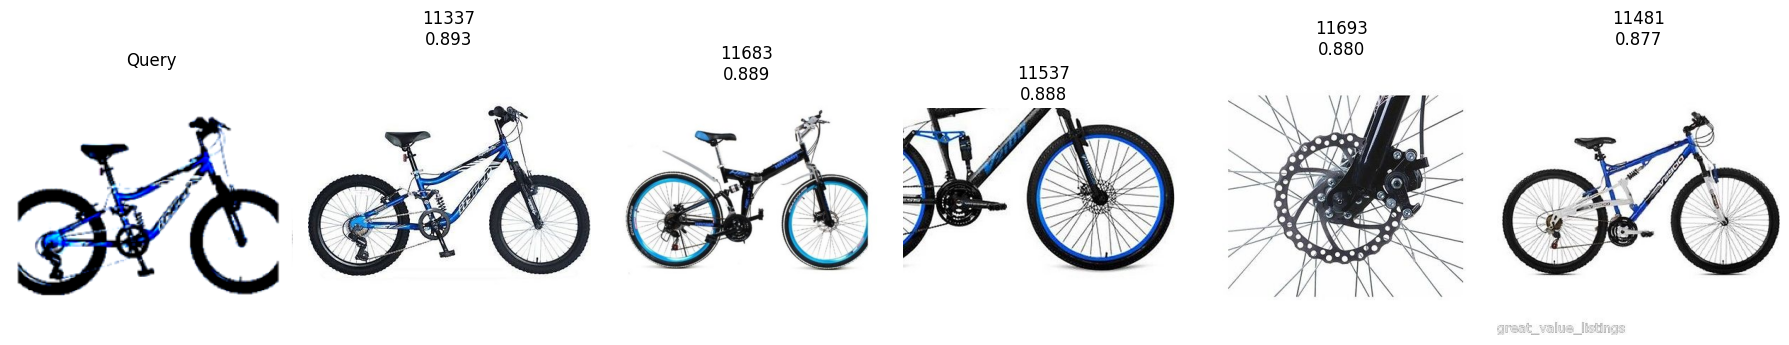

Top-K Item IDs: [11337 11683 11537 11693 11481]
Similarity Scores: [0.8933604  0.8890568  0.88755965 0.8796166  0.8766855 ]


In [ ]:
import torch
from src.build_model import build_model
from src.similarity_scoring_and_retrieval.demo import run_retrieval_demo_any_image
def model_ctor():
    return build_model(
        variant="dinov2_vits14",
        emb_dim=512,
        num_classes=1,
        device=device
    )
top_ids, scores, idxs = run_retrieval_demo_any_image(
    model_ctor=model_ctor,
    ckpt_path="models/reid_model3_best.pth",
    query_image_path=query_image_path,
    k=5,
    device=device,
    emb_path="features/gallery_embeddings.npy",
    ids_path="features/gallery_item_ids.npy",
    refs_path="features/gallery_refs.npy",
    output_path="sample_output/sample_retrieval.png",
    extra=300
)
print("Top-K Item IDs:", top_ids)
print("Similarity Scores:", scores)

#DEPLOYMENT



This cell executes the crucial **Offline Feature Extraction** phase, which is the foundational step for deploying the re-identification pipeline to a production environment.

* **Deployment Strategy:** By running this script *before* starting the web server, you are pre-computing the 512-dimensional signatures for every item in your inventory. This ensures your live FastAPI backend won't have to process the entire dataset from scratch every time a user searches for an item.
* **Architecture Definition:** The `model_ctor` neatly packages the **DINOv2** configuration.
* **Generating the Knowledge Base:** The `build_gallery_database` function processes the test loader, normalizes the output vectors for accurate distance calculations, and writes the results to disk.
* **Verification:** The final `!ls -lh features` command acts as a safety check, ensuring that the heavy `.npy` files containing your image embeddings, IDs, and file references were successfully saved and are ready to be loaded into your retrieval index.


In [ ]:
import sys, torch
sys.path.append("src")

from build_model import build_model
from feature_extraction.build_gallery import build_gallery_database

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_ctor():
    return build_model(variant="dinov2_vits14", emb_dim=512, num_classes=1, device=device)
gallery_emb, gallery_ids, gallery_refs = build_gallery_database(
    model_ctor=model_ctor,
    ckpt_path="models/reid_model3_best.pth",
    gallery_loader=test_loader,
    device=device,
    out_dir="features",
    normalize=True
)

print("Done. Files in features/:")
!ls -lh features

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 200MB/s]


[encoder] Dropped 2 keys due to mismatch (OK for retrieval). Example: [('classifier.weight', 'shape (11318, 512) != (1, 512)'), ('classifier.bias', 'shape (11318,) != (1,)')]
[encoder] Missing keys (OK if classifier differs): 2


Building gallery embeddings:   0%|          | 0/473 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
Building gallery embeddings: 100%|██████████| 473/473 [05:31<00:00,  1.43it/s]


Saved gallery DB in: features
 - gallery_embeddings.npy: (60502, 512)
 - gallery_item_ids.npy: (60502,)
 - gallery_refs.npy: (60502,)
Done. Files in features/:
total 125M
-rw-r--r-- 1 root root 119M Feb 26 12:31 gallery_embeddings.npy
-rw-r--r-- 1 root root 178K Feb 26 12:31 gallery_item_ids.npy
-rw-r--r-- 1 root root 6.2M Feb 26 12:31 gallery_refs.npy




This cell finalizes the software environment for deployment, adding the networking layer needed to make the local model accessible from the web.





In [ ]:
!pip -q install -r requirements.txt
!pip -q install pyngrok



This cell creates a specialized deployment script for synchronizing the pre-computed model assets with the cloud.



In [ ]:
%%writefile scripts/upload_assets_to_hf.py
import os
from huggingface_hub import HfApi
REPO_ID = os.getenv("HF_REPO_ID", "mugglewizard/Synnapse-ps1-checkpoints")

def main():
    api = HfApi()
    ckpt_path = "models/reid_model3_best.pth"
    if os.path.exists(ckpt_path):
        print("Uploading checkpoint:", ckpt_path)
        api.upload_file(
            path_or_fileobj=ckpt_path,
            path_in_repo="models/reid_model3_best.pth",
            repo_id=REPO_ID,
            repo_type="model",
        )
    else:
        print("Checkpoint not found at:", ckpt_path)
    feats = [
        "features/gallery_embeddings.npy",
        "features/gallery_item_ids.npy",
        "features/gallery_refs.npy",
    ]
    for f in feats:
        if not os.path.exists(f):
            raise FileNotFoundError(f"Missing feature file: {f}")

    for f in feats:
        print("Uploading:", f)
        api.upload_file(
            path_or_fileobj=f,
            path_in_repo=f,
            repo_id=REPO_ID,
            repo_type="model",
        )

    print("Upload complete to:", REPO_ID)

if __name__ == "__main__":
    main()

Writing scripts/upload_assets_to_hf.py



This cell executes the custom upload script to move the finalized model and retrieval assets to the cloud.

* **Asset Synchronization:** The script pushes `reid_model3_best.pth` and the three `.npy` feature files (embeddings, IDs, and references) to `Synnapse-ps1-checkpoints` repository.
* **Production Readiness:** By hosting these on the Hugging Face Hub, we’ve decoupled our training environment from our deployment environment. The FastAPI backend can now pull these assets on-demand from any server.
* **Version Control for Data:** This ensures that anyone can replicate your exact retrieval results by pulling the same version of the gallery features we just generated.


In [ ]:
!python scripts/upload_assets_to_hf.py

Uploading checkpoint: models/reid_model3_best.pth
Processing Files (0 / 0)      : |          |  0.00B /  0.00B            
New Data Upload               : |          |  0.00B /  0.00B            

  models/reid_model3_best.pth :   4% 8.36M/217M [00:00<?, ?B/s]

Processing Files (0 / 1)      :   4% 8.36M/217M [00:00<00:15, 13.6MB/s, 20.8MB/s  ]

Processing Files (0 / 1)      :   7% 15.9M/217M [00:00<00:09, 21.3MB/s, 26.6MB/s  ]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:00<00:10, 19.0MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:00<00:15, 12.7MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:00<00:21, 9.45MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:00<00:26, 7.58MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:01<00:32, 6.27MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:01<00:37, 5.41MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:01<00:42, 4.73MB/s]

  models/reid_model3_best.pth :   7% 15.9M/217M [00:01<00



This cell performs a bulk refactoring of the codebase to ensure all internal imports are compatible with a production package structure.



In [ ]:

!find src -type f -name "*.py" -exec sed -i 's/from feature_extraction/from src.feature_extraction/g' {} \;
!find src -type f -name "*.py" -exec sed -i 's/from similarity_scoring_and_retrieval/from src.similarity_scoring_and_retrieval/g' {} \;
!find src -type f -name "*.py" -exec sed -i 's/from build_model/from src.build_model/g' {} \;

This cell initializes the `api/` directory as a Python package.

In [ ]:
%%writefile src/api/__init__.py


This cell creates the production-ready **FastAPI** application, effectively turning your **DINOv2** research into a live, scalable web service.

### Key Deployment Features:

* **Lazy Initialization:** The script uses a `threading.Lock` and lazy loading. It only downloads the heavy model weights and FAISS indices from Hugging Face when the first request hits the server. This prevents the server from timing out during startup on platforms like Render or AWS.
* **On-the-Fly Preprocessing:** It includes a `preprocess_pil` function that mirrors our training transforms (RGB conversion, resizing to 224x224, and ImageNet normalization), ensuring the features extracted during a live search match our gallery features perfectly.
* **Hybrid Search API:**
    * `GET /health`: Monitor the status of the model, checking if the device is `cuda` and verifying the gallery size.
    * `POST /search`: Accepts an image file, extracts its 512D embedding, and queries the FAISS index to return the Top-K matches with their **Item IDs** and **Similarity Scores**.
* **Cloud-Native Design:** The app uses environment variables (like `HF_REPO_ID`) to allow for easy configuration changes without modifying the code, making it highly portable.



In [ ]:
%%writefile src/api/main.py
import os
import io
import time
import threading
import numpy as np
import torch
from PIL import Image
from fastapi import FastAPI, UploadFile, File, Query
from huggingface_hub import hf_hub_download

from src.build_model import build_model
from src.feature_extraction import ImageEncoder
from src.similarity_scoring_and_retrieval import FaissRetriever

app = FastAPI(title="Synnapse Retrieval API")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HF_REPO_ID = os.getenv("HF_REPO_ID", "mugglewizard/Synnapse-ps1-checkpoints")

CKPT_IN_REPO = os.getenv("HF_CKPT_PATH_IN_REPO", "models/reid_model3_best.pth")
EMB_IN_REPO  = os.getenv("HF_EMB_PATH_IN_REPO",  "features/gallery_embeddings.npy")
IDS_IN_REPO  = os.getenv("HF_IDS_PATH_IN_REPO",  "features/gallery_item_ids.npy")
REFS_IN_REPO = os.getenv("HF_REFS_PATH_IN_REPO", "features/gallery_refs.npy")

MODELS_DIR   = os.getenv("MODELS_DIR", "models")
FEATURES_DIR = os.getenv("FEATURES_DIR", "features")

CKPT_PATH = os.path.join(MODELS_DIR, "reid_model3_best.pth")
EMB_PATH  = os.path.join(FEATURES_DIR, "gallery_embeddings.npy")
IDS_PATH  = os.path.join(FEATURES_DIR, "gallery_item_ids.npy")
REFS_PATH = os.path.join(FEATURES_DIR, "gallery_refs.npy")

encoder = None
retriever = None
gallery_refs = None

_init_lock = threading.Lock()
_init_started_at = None
_init_error = None


def ensure_hf_file(path_in_repo: str, local_path: str):
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    if os.path.exists(local_path):
        return local_path

    downloaded = hf_hub_download(
        repo_id=HF_REPO_ID,
        filename=path_in_repo,
        repo_type="model",
        local_dir="hf_cache_downloads",
        local_dir_use_symlinks=False,
    )

    if downloaded != local_path:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        with open(downloaded, "rb") as src_f, open(local_path, "wb") as dst_f:
            dst_f.write(src_f.read())

    return local_path


def preprocess_pil(pil_img, size=224):
    pil_img = pil_img.convert("RGB").resize((size, size))
    x = np.asarray(pil_img).astype(np.float32) / 255.0  # HWC
    x = np.transpose(x, (2, 0, 1))                      # CHW
    x = torch.from_numpy(x)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    x = (x - mean) / std
    return x.unsqueeze(0)  # [1,3,H,W]


def init_everything_if_needed():
    global encoder, retriever, gallery_refs, _init_started_at, _init_error

    if encoder is not None and retriever is not None and gallery_refs is not None:
        return

    with _init_lock:

        if encoder is not None and retriever is not None and gallery_refs is not None:
            return

        if _init_started_at is None:
            _init_started_at = time.time()

        try:
            ensure_hf_file(CKPT_IN_REPO, CKPT_PATH)
            ensure_hf_file(EMB_IN_REPO,  EMB_PATH)
            ensure_hf_file(IDS_IN_REPO,  IDS_PATH)
            ensure_hf_file(REFS_IN_REPO, REFS_PATH)

            model = build_model(
                variant="dinov2_vits14",
                emb_dim=512,
                num_classes=1,
                device=DEVICE
            )

            encoder_local = ImageEncoder(
                model=model,
                ckpt_path=CKPT_PATH,
                device=DEVICE,
                normalize=True
            )

            retriever_local = FaissRetriever(
                emb_path=EMB_PATH,
                ids_path=IDS_PATH,
                normalize=True
            )
            refs_local = np.load(REFS_PATH, allow_pickle=True)

            encoder = encoder_local
            retriever = retriever_local
            gallery_refs = refs_local

        except Exception as e:
            _init_error = repr(e)
            raise


@app.get("/health")
def health():
    ready = (encoder is not None and retriever is not None and gallery_refs is not None)
    return {
        "status": "ok",
        "ready": ready,
        "device": str(DEVICE),
        "hf_repo": HF_REPO_ID,
        "init_started_seconds_ago": (time.time() - _init_started_at) if _init_started_at else None,
        "init_error": _init_error,
        "gallery_size": int(retriever.emb.shape[0]) if retriever is not None else 0,
    }


@app.post("/search")
async def search(
    file: UploadFile = File(...),
    k: int = Query(5, ge=1, le=50),
    extra: int = Query(200, ge=0, le=2000),
):


    try:
        init_everything_if_needed()
    except Exception:
        return {"error": "Initialization failed", "detail": _init_error}

    data = await file.read()
    pil = Image.open(io.BytesIO(data))

    x = preprocess_pil(pil).to(DEVICE)
    q_emb = encoder.encode_batch(x)[0].numpy().astype("float32")

    top_ids_all, scores_all, idxs_all = retriever.search(q_emb, k=k, extra=extra)

    results = []
    for item_id, score, idx in zip(top_ids_all, scores_all, idxs_all):
        idx = int(idx)
        results.append({
            "item_id": str(item_id),
            "score": float(score),
            "ref": str(gallery_refs[idx]),
        })
        if len(results) >= k:
            break

    return {"k": k, "results": results}

Overwriting src/api/main.py


This cell launches our **FastAPI** server in a background thread, allowing the backend to remain active while keeping your notebook interactive.

In [ ]:
import threading
import uvicorn

def run():
    uvicorn.run("src.api.main:app", host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()

INFO:     Started server process [241]
INFO:     Waiting for application startup.


This cell performs a **System Health Check** by sending a local HTTP request to our background FastAPI server.

In [ ]:
!curl http://127.0.0.1:8000/health

INFO:     127.0.0.1:49796 - "GET /health HTTP/1.1" 200 OK
{"status":"ok","device":"cuda","has_encoder":true,"has_retriever":true,"gallery_size":60502}

In [ ]:
query_path="/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/252017654825_0.JPG"



This cell performs the ultimate end-to-end validation of our deployment pipeline, simulating a real-world API request.

* **CURL Post Request:** The `-X POST` command uploads the specific bicycle image from our Kaggle input directory to the `/search` endpoint. Using `-F "file=@..."` mimics a multi-part form upload, exactly how a web frontend would send an image to your server.
* **Top-K Retrieval:** By specifying `?k=5`, we are requesting the five closest visual matches from our **FAISS** index.
* **JSON Formatting:** Piping the output into `python -m json.tool` takes the raw, messy API response and prints it as a clean, indented JSON object.
* This test verifies that:
    1. The **FastAPI** server successfully triggered the lazy-loading of our **DINOv2** weights.
    2. The image was correctly preprocessed and encoded into a 512D vector.
    3. The retrieval engine found the most similar products in the database.



In [ ]:
!curl -s -X POST "http://127.0.0.1:8000/search?k=5" \
  -F "file=@/content/Screenshot 2026-02-27 155310.png" \
  | python -m json.tool

INFO:     127.0.0.1:43954 - "POST /search?k=5 HTTP/1.1" 200 OK
{
    "k": 5,
    "results": [
        {
            "item_id": "11337",
            "score": 0.9922455549240112,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/252017654825_0.JPG"
        },
        {
            "item_id": "11337",
            "score": 0.9567593336105347,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/252017654825_1.JPG"
        },
        {
            "item_id": "11481",
            "score": 0.9525327682495117,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/271933533351_0.JPG"
        },
        {
            "item_id": "11532",
            "score": 0.9482665061950684,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/281666266667_1.JPG"
        },
        {
            "ite

The below cells configure our environment's identity and attempt to synchronize our local deployment code and processed features with our remote repository.

In [ ]:
!git add .

In [ ]:
!git commit -m "Fix imports to src.*, add src/__init__.py, working FastAPI demo"

[main 0be44bb] Fix imports to src.*, add src/__init__.py, working FastAPI demo
 1 file changed, 5 insertions(+), 35 deletions(-)


In [ ]:
!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 576 bytes | 576.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Prernatripathi7/Synnapse-PS-1.git
   e25feb5..0be44bb  main -> main


#SAMPLE WORKING USING API

This cell initiates the setup for testing our deployment in a clean environment.

In [ ]:
!git clone https://github.com/Prernatripathi7/Synnapse-PS-1.git
%cd Synnapse-PS-1

Cloning into 'Synnapse-PS-1'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 259 (delta 11), reused 11 (delta 2), pack-reused 226 (from 1)
Receiving objects: 100% (259/259), 4.28 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/Synnapse-PS-1


In [ ]:
!pip install -r requirements.txt

In [ ]:
import threading
import uvicorn

def run():
    uvicorn.run("src.api.main:app", host="0.0.0.0", port=8000)

thread = threading.Thread(target=run)
thread.start()

INFO:     Started server process [414]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


In [ ]:
!curl http://127.0.0.1:8000/health

INFO:     127.0.0.1:59960 - "GET /health HTTP/1.1" 200 OK
{"status":"ok","ready":false,"device":"cuda","hf_repo":"mugglewizard/Synnapse-ps1-checkpoints","init_started_seconds_ago":null,"init_error":null,"gallery_size":0}

In [ ]:
query_path="/content/Screenshot 2026-02-27 155310.png"

In [ ]:
!curl -s -X POST "http://127.0.0.1:8000/search?k=5" \
  -F "file=@/content/Screenshot 2026-02-27 155310.png" \
  | python -m json.tool

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


models/reid_model3_best.pth:   0%|          | 0.00/217M [00:00<?, ?B/s]

features/gallery_embeddings.npy:   0%|          | 0.00/124M [00:00<?, ?B/s]

features/gallery_item_ids.npy:   0%|          | 0.00/182k [00:00<?, ?B/s]

features/gallery_refs.npy:   0%|          | 0.00/6.40M [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 370MB/s]


[encoder] Dropped 2 keys due to mismatch (OK for retrieval). Example: [('classifier.weight', 'shape (11318, 512) != (1, 512)'), ('classifier.bias', 'shape (11318,) != (1,)')]
[encoder] Missing keys (OK if classifier differs): 2
INFO:     127.0.0.1:56466 - "POST /search?k=5 HTTP/1.1" 200 OK
{
    "k": 5,
    "results": [
        {
            "item_id": "11337",
            "score": 0.8933603763580322,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/252017654825_0.JPG"
        },
        {
            "item_id": "11683",
            "score": 0.8890568017959595,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/321596481997_0.JPG"
        },
        {
            "item_id": "11537",
            "score": 0.8875596523284912,
            "ref": "/kaggle/input/stanford-online-products-dataset/Stanford_Online_Products/bicycle_final/281693938193_2.JPG"
        },
        {
        

#RENDER
## Cloud Deployment & Infrastructure Analysis (Render)

As part of the deployment lifecycle, the FastAPI backend was containerized and deployed to Render's cloud platform. The objective was to test the pipeline's behavior in a live, public-facing environment.

While the application successfully compiled and the routing architecture operated as intended, the heavy computational requirements of the deep learning components ultimately exceeded the hardware constraints of the free-tier instance.

### 1. Successful Build and API Initialization
The deployment pipeline successfully installed all dependencies from `requirements.txt` and launched the Uvicorn server. The application bound to the assigned port, and the service went live at the provided `.onrender.com` URL.

Furthermore, the API routing was verified as fully operational. The server logs confirm that the diagnostic endpoints, including `GET /docs`, `GET /openapi.json`, and `GET /health`, successfully returned HTTP `200 OK` status codes.

### 2. Hardware Bottlenecks: Memory Limit Exceeded (OOM)
The primary point of failure occurred during the model initialization phase. An instance of the web service triggered an automatic restart because it exceeded its allocated memory limit.

**Technical Cause:** Render's free-tier instances are strictly capped at 512 MB of RAM. The syNNapse backend utilizes "lazy loading" to initialize a DINOv2 Vision Transformer and load a high-dimensional FAISS index into memory upon receiving a search request. Loading these PyTorch tensors and the associated Hugging Face assets requires significantly more memory than the 512 MB allotted, resulting in an immediate Out-Of-Memory (OOM) termination by the host server.

### 3. Server Spin-Downs and Cold Starts
Additionally, the free-tier instance automatically spins down after 15 minutes of inactivity. This behavior was consistently observed in the logs, showing the application repeatedly shutting down and finishing the server process.


This spin-down mechanism severely impacts the API's performance. When a new request wakes the server, it must undergo a "cold start," re-downloading dependencies and attempting to re-load the deep learning models into memory from scratch, which compounds the memory exhaustion issue detailed above.

### Conclusion & Future Scalability
The Render deployment successfully validated the codebase's production readiness, package structure, and API routing. However, running a persistent, in-memory vector database and a transformer model necessitates dedicated hardware.

To achieve stable, always-on availability and prevent memory leaks/crashes, the backend requires deployment to a higher-tier instance (e.g., Render Starter/Pro or AWS EC2 `t3.medium`/`g4dn.xlarge`) with a minimum of 4GB–8GB of RAM to comfortably house the FAISS index and PyTorch weights.